# **モース硬度データセットを使用した回帰**
(Regression-with-a-Mohs- Hardness-Dataset)

# 参考資料
- Pandasクックブック Pythonによるデータ処理のレシピ
- NumPy & SciPy数値計算実装ハンドブック数値シミュレーション入門者のための
- 東京大学のデータサイエンティスト育成講座 Pythonで手を動かして学ぶデ―タ分析
- Matplotlib & Seaborn実装ハンドブックより美しい統計データ可視化のための
- Pythonで学ぶビジネスデータの予測モデル

**Kaggle**
- [🧱🧰🔨💎🏭 Kapturov's solution of PS S3E25](https://www.kaggle.com/code/cheesegue/kapturov-s-solution-of-ps-s3e25)
- [My Beauty Notebook ❤](https://www.kaggle.com/code/lasm1984/my-beauty-notebook)
- [PS-S3-Ep25 | EDA 📊 | Modeling + Submission 🚀](https://www.kaggle.com/code/oscarm524/ps-s3-ep25-eda-modeling-submission)
- [PS_3.24_LGBM_bin_日本語あり](https://www.kaggle.com/code/akioonodera/ps-3-24-lgbm-bin)
- [PS-S3-Ep24 | EDA 📊 | Modeling + Submission 🚀](https://www.kaggle.com/code/oscarm524/ps-s3-ep24-eda-modeling-submission)
- [PS3E24 | EDA | Feature Engineering | Ensemble](https://www.kaggle.com/code/arunklenin/ps3e24-eda-feature-engineering-ensemble)

**記事**  
- [sweetvizの記事](https://qiita.com/d_sato_/items/0485af3b0a9271a71c88)

## 概要
1. 目的： [鉱物の性質からモース硬度を回帰を用いて予測すること](https://www.kaggle.com/competitions/playground- series-s3e25)
2. アプローチ: この研究は、著者が物理的および光学的特性から、天然素材を直接含んだ鉱物の組み合わせの特徴の性質を特徴づけるCRC Handbook45からデータベースを構築した。
3. データセット:
    1. 実験的なモース硬度データと結晶クラス。
    2. 物性と鉱物データベースから派生。
    3. 369種類の鉱物からなるデータセット。

#### 評価指標：　Median Absolute Error（MedAE）
- 残差の絶対値の中央値がMedAEです。
- MAEよりも更に外れ値に堅牢（ロバスト）な評価指標です。

# ライブラリ・データセットのインポート

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display
import sweetviz as sv

import warnings; warnings.filterwarnings("ignore")

# pd.set_option('display.max_columns', 30)
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
plt.style.use('ggplot')

In [4]:
from sklearn.ensemble import RandomForestRegressor
import missingno as msno

## 実行時間を調べるために使う

In [5]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [6]:
FILE_PATH = '/kaggle/input/playground-series-s3e25'
OUTPUT_DIR = '/kaggle/working/'
train = pd.read_csv(FILE_PATH + '/train.csv')
test = pd.read_csv(FILE_PATH + '/test.csv')

## id と目的変数（Hardness）の分割

In [7]:
train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

target = train['Hardness']
target_name = str(train.iloc[:, [11]].columns.tolist())

## データ(DataFrame)の構成を調べる

In [8]:
train.head()

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
0               100.0       0.841611                  10.0            4.8   
1               100.0       7.558488                  10.0            4.8   
2                76.0       8.885992                  15.6            5.6   
3               100.0       8.795296                  10.0            4.8   
4               116.0       9.577996                  11.6            4.8   

   atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0             20.612526           11.08810               2.766   
1             20.298893           12.04083               2.755   
2             33.739258           12.08630               2.828   
3             20.213349           10.94850               2.648   
4             24.988133           11.82448               2.766   

   R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                  1.732                  0.860         0.496070   
1                  1.631                  0.910         0.492719   
2                  1.788                  0.864         0.481478   
3                  1.626                  0.936         0.489272   
4                  1.682                  0.896         0.492736   

   density_Average  Hardness  
0          0.91457       6.0  
1          0.71760       6.5  
2          1.50633       2.5  
3          0.78937       6.0  
4          1.86481       6.0

In [9]:
test.head()

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
0               884.0     121.420000                 35.36           5.28   
1                90.0       9.931960                 18.00           5.60   
2               116.0       7.767992                 11.60           4.80   
3               100.0       9.107996                 10.00           4.80   
4                55.0       4.030000                 11.00           4.00   

   atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0             82.561240           9.370384               2.298   
1             39.568056          12.086300               2.868   
2             23.231818          11.023840               2.644   
3             20.298893          12.086300               2.828   
4             22.977675          11.280950               2.455   

   R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                 1.9072               1.200000         0.461899   
1                 1.6520               0.864000         0.476196   
2                 1.7940               0.960000         0.499514   
3                 1.6620               0.792000         0.495796   
4                 1.7500               0.893333         0.476095   

   density_Average  
0          1.79459  
1          1.41194  
2          0.78834  
3          1.20466  
4          0.93456

In [10]:
print('train: ')
print(train.shape)
print(train.info())

train: 
(10407, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB
None


In [11]:
print('test: ')
print(test.shape)
print(test.info())

test: 
(6939, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6939 entries, 0 to 6938
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     6939 non-null   float64
 1   density_Total          6939 non-null   float64
 2   allelectrons_Average   6939 non-null   float64
 3   val_e_Average          6939 non-null   float64
 4   atomicweight_Average   6939 non-null   float64
 5   ionenergy_Average      6939 non-null   float64
 6   el_neg_chi_Average     6939 non-null   float64
 7   R_vdw_element_Average  6939 non-null   float64
 8   R_cov_element_Average  6939 non-null   float64
 9   zaratio_Average        6939 non-null   float64
 10  density_Average        6939 non-null   float64
dtypes: float64(11)
memory usage: 596.4 KB
None


In [12]:
train_columns = train.columns
train_index = train.index
train_data = train.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_columns))
print(type(train_index))
print(type(train_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [13]:
with pd.option_context('display.max_rows', 8):
    display(train)

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
0                   100.0       0.841611             10.000000       4.800000   
1                   100.0       7.558488             10.000000       4.800000   
2                    76.0       8.885992             15.600000       5.600000   
3                   100.0       8.795296             10.000000       4.800000   
...                   ...            ...                   ...            ...   
10403                30.0       1.743160             10.000000       5.333333   
10404               196.0      30.920000             24.500000       5.500000   
10405                38.0       1.553160             12.666667       4.666667   
10406               288.0      24.655328             11.142857       4.571429   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0                 20.612526          11.088100            2.766000   
1                 20.298893          12.040830            2.755000   
2                 33.739258          12.086300            2.828000   
3                 20.213349          10.948500            2.648000   
...                     ...                ...                 ...   
10403             20.766935          14.163933            3.090000   
10404             53.490297          10.074300            2.295000   
10405             26.621687          11.290033            2.743333   
10406             22.536126          10.960357            2.792143   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                   1.732000               0.860000         0.496070   
1                   1.631000               0.910000         0.492719   
2                   1.788000               0.864000         0.481478   
3                   1.626000               0.936000         0.489272   
...                      ...                    ...              ...   
10403               1.556667               0.866667         0.480390   
10404               1.545000               1.120000         0.469715   
10405               1.756667               0.980000         0.486507   
10406               1.772857               0.940000         0.493919   

       density_Average  Hardness  
0              0.91457       6.0  
1              0.71760       6.5  
2              1.50633       2.5  
3              0.78937       6.0  
...                ...       ...  
10403          0.81480       5.0  
10404          2.11540       1.8  
10405          0.77755       6.0  
10406          0.97737       6.5  

[10407 rows x 12 columns]

In [14]:
with pd.option_context('display.max_rows', 8):
    display(test)

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
0                  884.0     121.420000             35.360000       5.280000   
1                   90.0       9.931960             18.000000       5.600000   
2                  116.0       7.767992             11.600000       4.800000   
3                  100.0       9.107996             10.000000       4.800000   
...                  ...            ...                   ...            ...   
6935                36.0       3.550000             18.000000       4.000000   
6936                68.0       4.545328             11.333333       5.333333   
6937                40.0       2.334164              6.666667       4.000000   
6938               134.0      17.590000             67.000000       5.000000   

      atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0                82.561240           9.370384            2.298000   
1                39.568056          12.086300            2.868000   
2                23.231818          11.023840            2.644000   
3                20.298893          12.086300            2.828000   
...                    ...                ...                 ...   
6935             36.068500           8.236600            1.790000   
6936             22.688853          10.938358            2.876667   
6937             13.016128          12.700467            2.770000   
6938            167.400000           8.213150            1.950000   

      R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                  1.907200               1.200000         0.461899   
1                  1.652000               0.864000         0.476196   
2                  1.794000               0.960000         0.499514   
3                  1.662000               0.792000         0.495796   
...                     ...                    ...              ...   
6935               2.055000               1.390000         0.499000   
6936               1.713333               0.916667         0.499074   
6937               1.476667               0.616667         0.663797   
6938               2.040000               1.410000         0.401635   

      density_Average  
0             1.79459  
1             1.41194  
2             0.78834  
3             1.20466  
...               ...  
6935          1.35045  
6936          0.73425  
6937          0.51227  
6938          0.44035  

[6939 rows x 11 columns]

## データ型を理解する

In [15]:
print('train: ')
print(train.dtypes)
print(train.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train: 
allelectrons_Total       float64
density_Total            float64
allelectrons_Average     float64
val_e_Average            float64
atomicweight_Average     float64
ionenergy_Average        float64
el_neg_chi_Average       float64
R_vdw_element_Average    float64
R_cov_element_Average    float64
zaratio_Average          float64
density_Average          float64
Hardness                 float64
dtype: object
float64    12
Name: count, dtype: int64


test: 
allelectrons_Total       float64
density_Total            float64
allelectrons_Average     float64
val_e_Average            float64
atomicweight_Average     float64
ionenergy_Average        float64
el_neg_chi_Average       float64
R_vdw_element_Average    float64
R_cov_element_Average    float64
zaratio_Average          float64
density_Average          float64
dtype: object
float64    11
Name: count, dtype: int64


すべての変数がfloat64(浮動小数点)

# EDA(探索的データ分析)

What's your EDA?  
**EDA(探索的データ分析)**: データセットに適宜前処理を施しつつ様々な統計量を抽出して可視化し、そこに内在する特性・パターン・偏りについて探索的に仮説立案・検証を繰り返して分析すること

## 要約統計量

In [16]:
train.describe().T

count        mean         std  min        25%  \
allelectrons_Total     10407.0  128.053516  224.123776  0.0  68.000000   
density_Total          10407.0   14.491342   15.972877  0.0   7.558488   
allelectrons_Average   10407.0   17.033222   10.468734  0.0  10.000000   
val_e_Average          10407.0    4.546789    0.690864  0.0   4.000000   
atomicweight_Average   10407.0   37.507703   26.012313  0.0  20.298893   
ionenergy_Average      10407.0   10.938308    1.408276  0.0  10.590660   
el_neg_chi_Average     10407.0    2.607662    0.334906  0.0   2.530000   
R_vdw_element_Average  10407.0    1.731330    0.192481  0.0   1.672500   
R_cov_element_Average  10407.0    0.944132    0.180017  0.0   0.864000   
zaratio_Average        10407.0    0.493349    0.063080  0.0   0.476196   
density_Average        10407.0    2.132984    1.936656  0.0   0.814800   
Hardness               10407.0    4.647126    1.680525  1.0   3.000000   

                              50%         75%           max  
allelectrons_Total     100.000000  131.000000  15300.000000  
density_Total           10.650000   16.676996    643.093804  
allelectrons_Average    12.600000   22.000000     67.000000  
val_e_Average            4.714286    4.800000      6.000000  
atomicweight_Average    26.203827   48.719500    167.400000  
ionenergy_Average       11.202760   11.670725     15.245810  
el_neg_chi_Average       2.706000    2.805000      3.443000  
R_vdw_element_Average    1.732727    1.800000      2.250000  
R_cov_element_Average    0.915556    0.981667      1.615840  
zaratio_Average          0.488550    0.496070      0.825990  
density_Average          1.351550    2.741550     10.970000  
Hardness                 5.500000    6.000000     10.000000

In [17]:
test.describe().T

count        mean         std  min        25%  \
allelectrons_Total     6939.0  126.460128  207.564499  0.0  68.000000   
density_Total          6939.0   14.794020   18.982447  0.0   7.558488   
allelectrons_Average   6939.0   17.406186   10.996089  0.0  10.000000   
val_e_Average          6939.0    4.546852    0.683158  0.0   4.000000   
atomicweight_Average   6939.0   38.422790   27.344351  0.0  20.298893   
ionenergy_Average      6939.0   10.921512    1.378980  0.0  10.584314   
el_neg_chi_Average     6939.0    2.608119    0.322873  0.0   2.527500   
R_vdw_element_Average  6939.0    1.737907    0.190584  0.0   1.678000   
R_cov_element_Average  6939.0    0.949638    0.179266  0.0   0.866667   
zaratio_Average        6939.0    0.491675    0.060829  0.0   0.476095   
density_Average        6939.0    2.152065    1.958213  0.0   0.812440   

                              50%         75%           max  
allelectrons_Total     100.000000  128.000000  10116.000000  
density_Total           10.650000   16.601328    643.093804  
allelectrons_Average    12.666667   22.000000     67.000000  
val_e_Average            4.750000    4.800000      6.000000  
atomicweight_Average    26.203827   48.719500    167.400000  
ionenergy_Average       11.202760   11.645560     15.245810  
el_neg_chi_Average       2.706000    2.806667      3.443000  
R_vdw_element_Average    1.736000    1.820000      2.250000  
R_cov_element_Average    0.920000    0.990000      1.615333  
zaratio_Average          0.488550    0.496118      0.825990  
density_Average          1.351550    2.780220     10.970000

In [18]:
# 特定の次元方向についての分散
print('train: ')
print(np.var(train, axis=0))
print('\n')
print('test: ')
print(np.var(test, axis=0))

train: 
allelectrons_Total       50226.640420
density_Total              255.108273
allelectrons_Average       109.583862
val_e_Average                0.477247
atomicweight_Average       676.575409
ionenergy_Average            1.983050
el_neg_chi_Average           0.112151
R_vdw_element_Average        0.037045
R_cov_element_Average        0.032403
zaratio_Average              0.003979
density_Average              3.750275
Hardness                     2.823894
dtype: float64


test: 
allelectrons_Total       43076.812368
density_Total              360.281362
allelectrons_Average       120.896553
val_e_Average                0.466638
atomicweight_Average       747.605784
ionenergy_Average            1.901313
el_neg_chi_Average           0.104232
R_vdw_element_Average        0.036317
R_cov_element_Average        0.032132
zaratio_Average              0.003700
density_Average              3.834044
dtype: float64


In [19]:
train.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

In [20]:
test.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

### 変動係数

変動係数は、標準偏差を平均値で割った値
* スケールに依存せず、比較できるようになる

In [21]:
train.std() / train.mean()

allelectrons_Total       1.750235
density_Total            1.102236
allelectrons_Average     0.614607
val_e_Average            0.151945
atomicweight_Average     0.693519
ionenergy_Average        0.128747
el_neg_chi_Average       0.128431
R_vdw_element_Average    0.111175
R_cov_element_Average    0.190669
zaratio_Average          0.127861
density_Average          0.907956
Hardness                 0.361627
dtype: float64

## 欠損値

In [22]:
print('train: ')
# print(train.isna().sum().sort_values(ascending=False) / train.shape[0] * 100)
print(train.isnull().sum())
print('\n')
print('test: ')
# print(test.isna().sum().sort_values(ascending=False) / train.shape[0] * 100)
print(test.isnull().sum())

train: 
allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64


test: 
allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
dtype: int64


<Axes: >

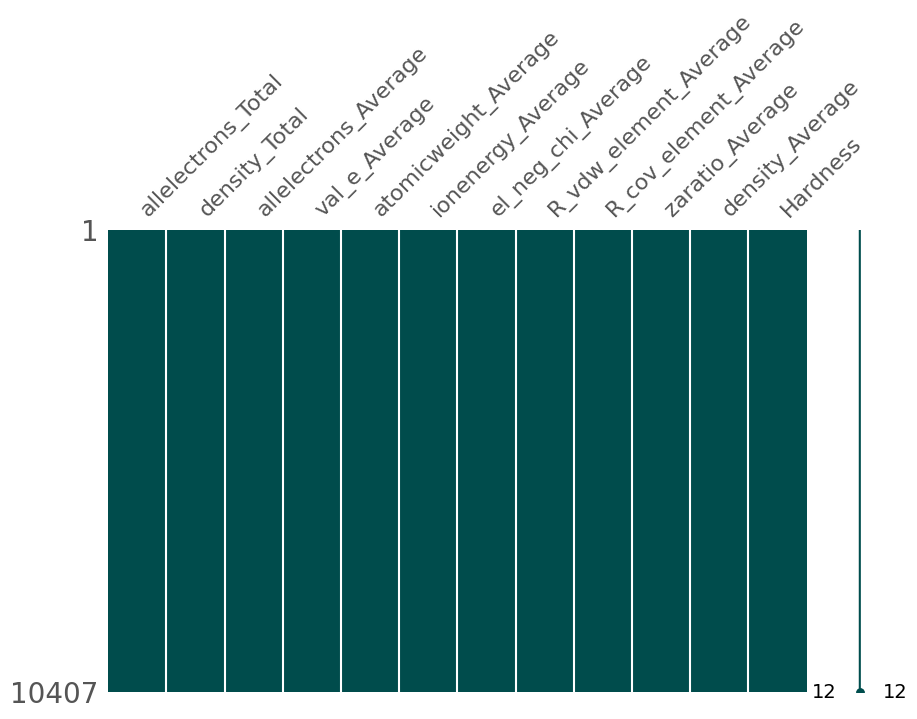

In [23]:
# 欠損値の有無を可視化する
msno.matrix(df=train, figsize=(10, 6), color=(0, .3, .3))

元々欠損値がないデータ

## 尖度（せんど）と歪度（わいど）

- 分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標のこと
- 分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度

In [24]:
print('train: ')
print(train.kurtosis())
print('\n')
print('test: ')
print(test.kurtosis())

train: 
allelectrons_Total       2383.425529
density_Total             259.161522
allelectrons_Average        2.740956
val_e_Average              12.494568
atomicweight_Average        3.332072
ionenergy_Average          24.733284
el_neg_chi_Average         22.175230
R_vdw_element_Average      40.696122
R_cov_element_Average       5.156704
zaratio_Average            24.828071
density_Average             2.422794
Hardness                   -0.793775
dtype: float64


test: 
allelectrons_Total       1556.276209
density_Total             313.397231
allelectrons_Average        2.668006
val_e_Average              11.225967
atomicweight_Average        3.227547
ionenergy_Average          23.335279
el_neg_chi_Average         20.556445
R_vdw_element_Average      40.880686
R_cov_element_Average       5.075099
zaratio_Average            27.667758
density_Average             2.115909
dtype: float64


### 目的変数の尖度と歪度

In [25]:
# skewness and kurtosis
print("尖度: %f" % target.skew())
print("歪度: %f" % target.kurt())

尖度: -0.125749
歪度: -0.793775


## データセットのプロット（分布）

### 密度関数（ヒストグラム）

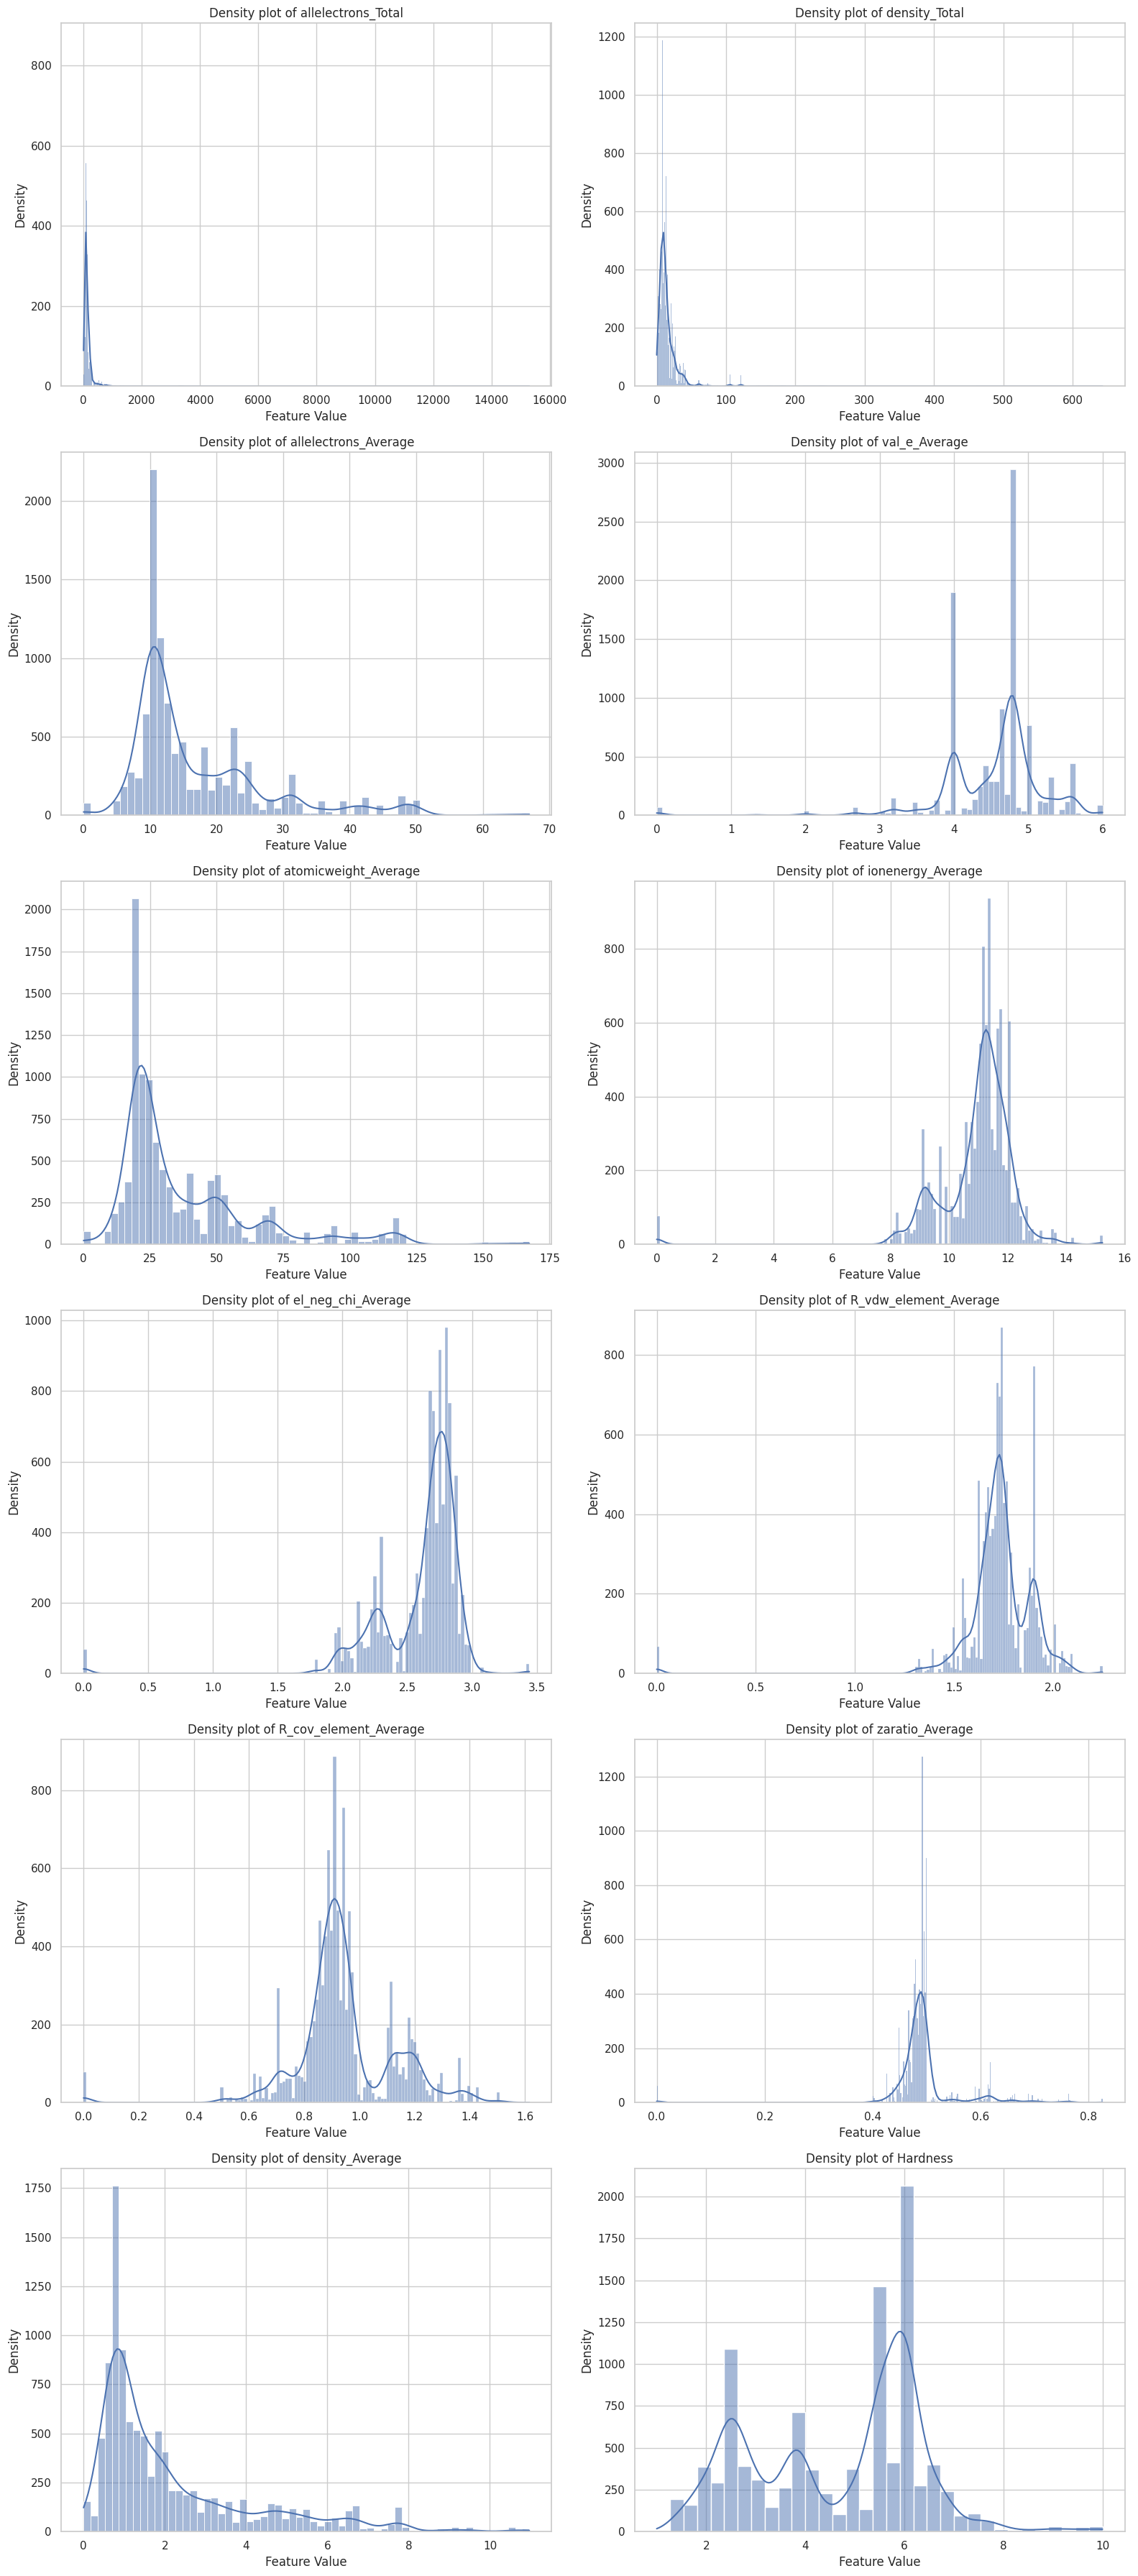

In [26]:
numeric_columns = train.select_dtypes(include=['float', 'int']).columns

sns.set(style="whitegrid")

num_plots = len(numeric_columns)
rows = (num_plots + 1) // 2
cols = 2
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

for i, feature_name in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, cols)
    sns.histplot(data=train, x=feature_name, kde=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Density plot of {feature_name}')
    axes[row_idx, col_idx].set_xlabel('Feature Value')
    axes[row_idx, col_idx].set_ylabel('Density')

plt.tight_layout()

plt.show()

array([[<Axes: title={'center': 'allelectrons_Total'}>,
        <Axes: title={'center': 'density_Total'}>,
        <Axes: title={'center': 'allelectrons_Average'}>],
       [<Axes: title={'center': 'val_e_Average'}>,
        <Axes: title={'center': 'atomicweight_Average'}>,
        <Axes: title={'center': 'ionenergy_Average'}>],
       [<Axes: title={'center': 'el_neg_chi_Average'}>,
        <Axes: title={'center': 'R_vdw_element_Average'}>,
        <Axes: title={'center': 'R_cov_element_Average'}>],
       [<Axes: title={'center': 'zaratio_Average'}>,
        <Axes: title={'center': 'density_Average'}>,
        <Axes: title={'center': 'Hardness'}>]], dtype=object)

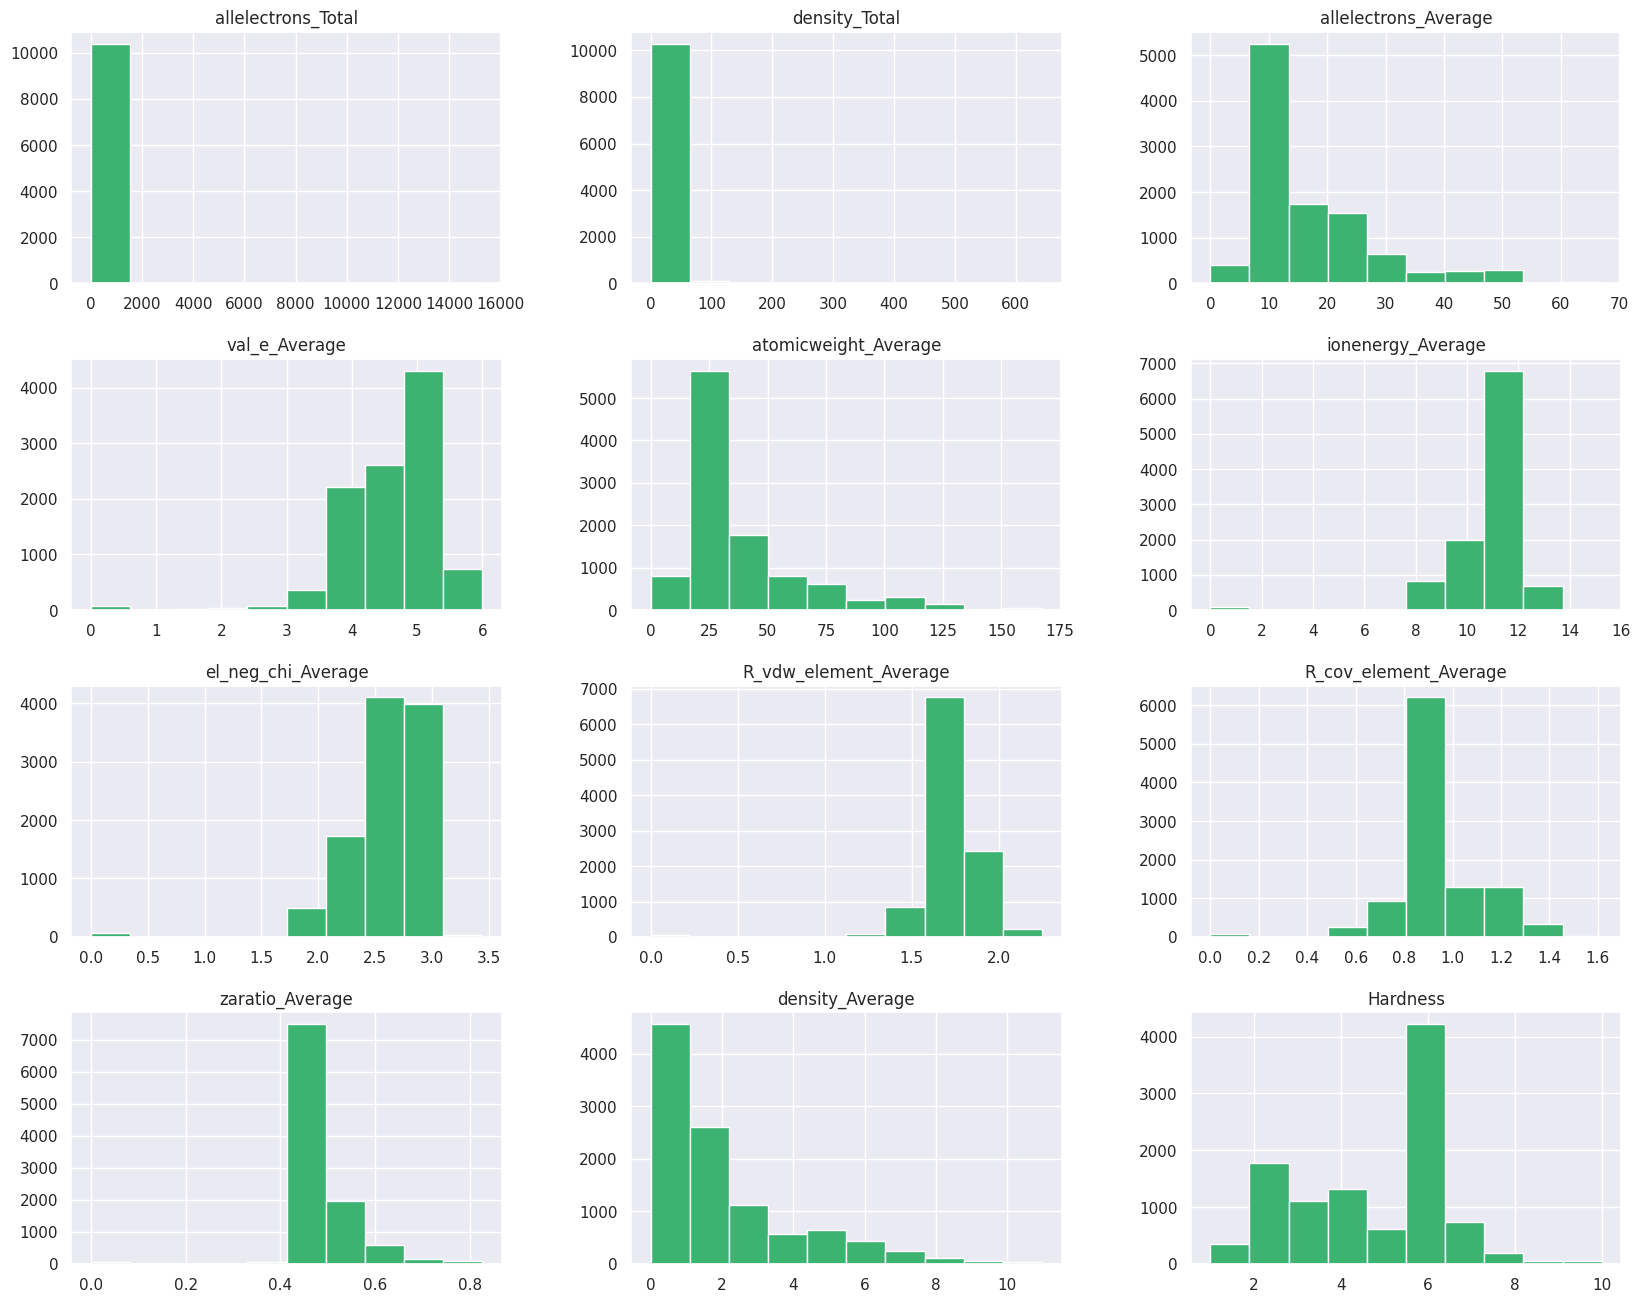

In [27]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='mediumseagreen')

array([[<Axes: title={'center': 'allelectrons_Total'}>,
        <Axes: title={'center': 'density_Total'}>,
        <Axes: title={'center': 'allelectrons_Average'}>],
       [<Axes: title={'center': 'val_e_Average'}>,
        <Axes: title={'center': 'atomicweight_Average'}>,
        <Axes: title={'center': 'ionenergy_Average'}>],
       [<Axes: title={'center': 'el_neg_chi_Average'}>,
        <Axes: title={'center': 'R_vdw_element_Average'}>,
        <Axes: title={'center': 'R_cov_element_Average'}>],
       [<Axes: title={'center': 'zaratio_Average'}>,
        <Axes: title={'center': 'density_Average'}>, <Axes: >]],
      dtype=object)

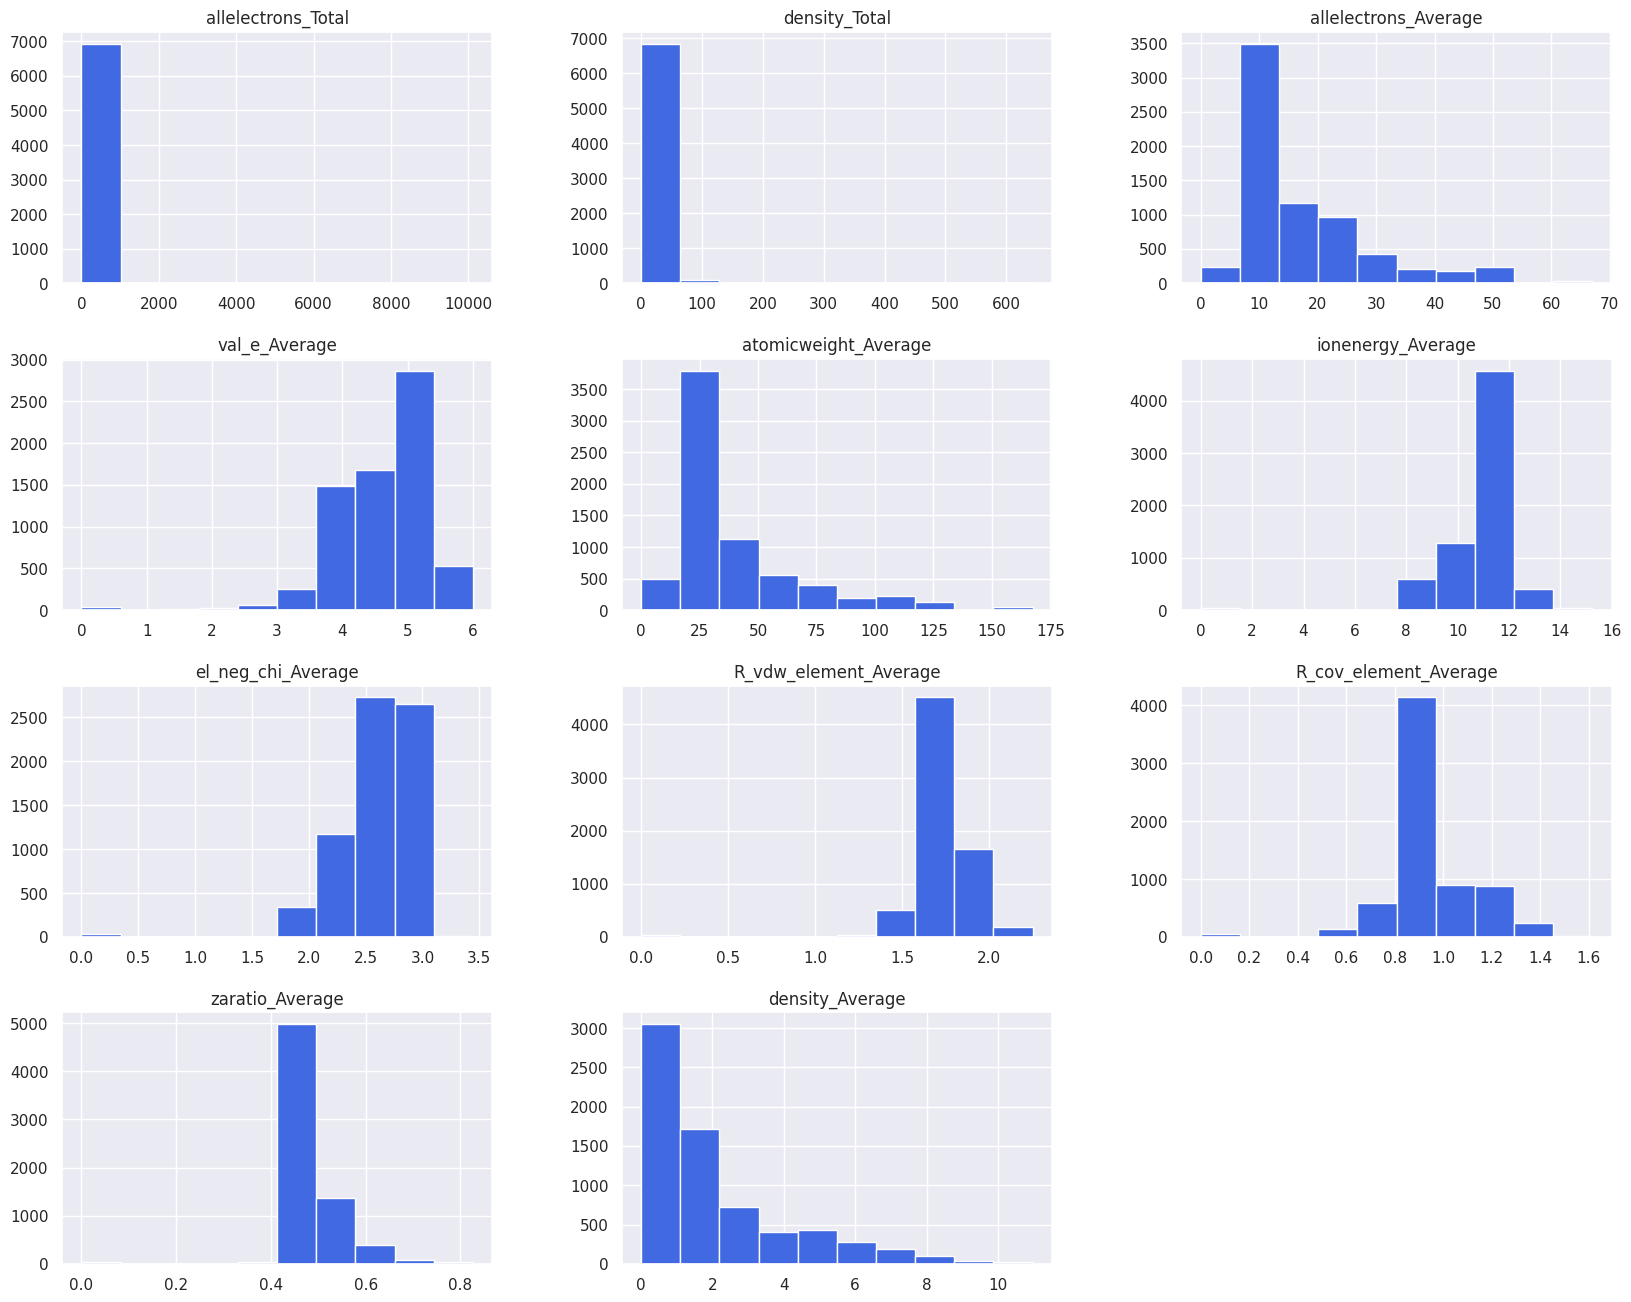

In [28]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')

#### データの分布を可視化する

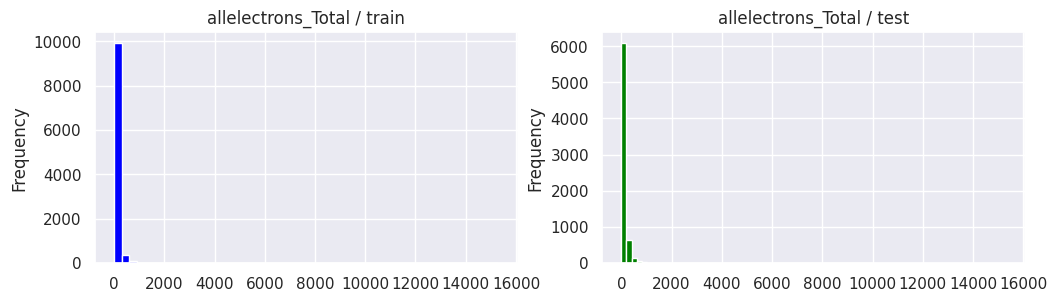

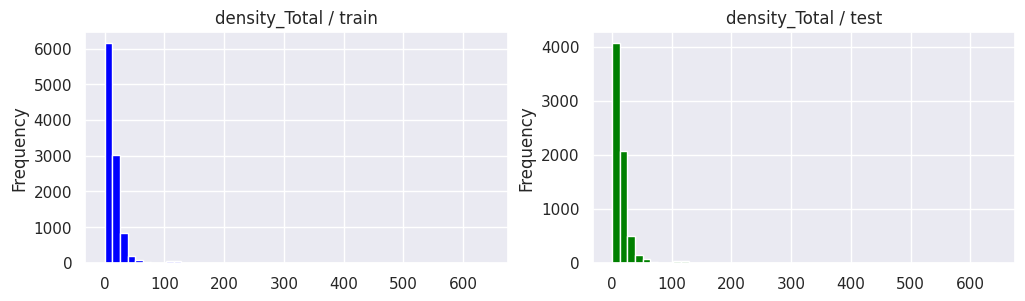

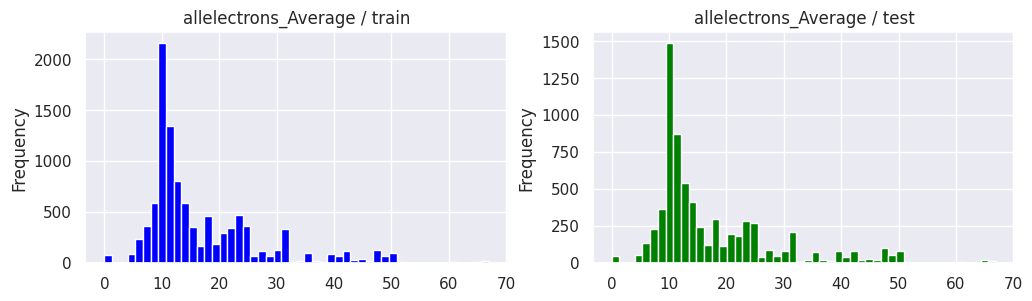

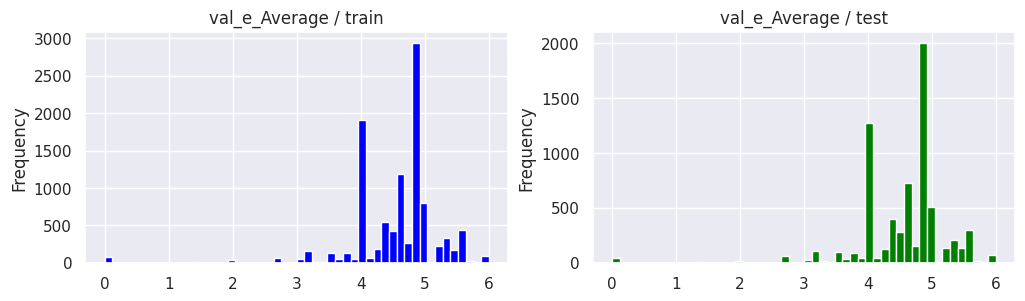

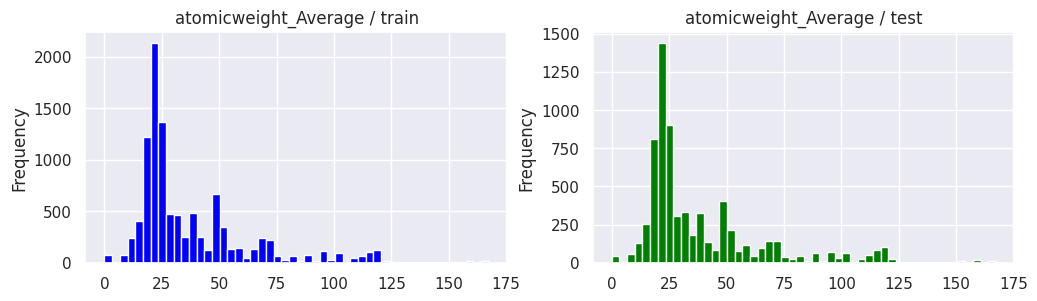

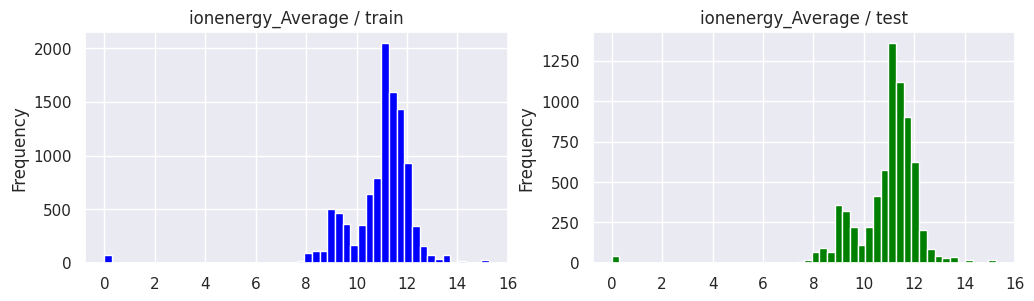

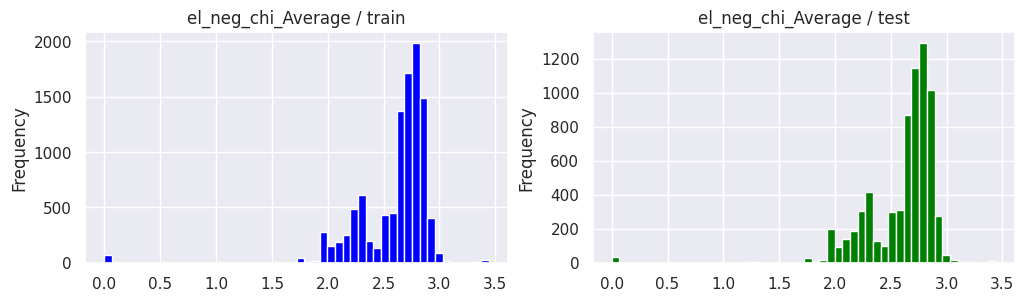

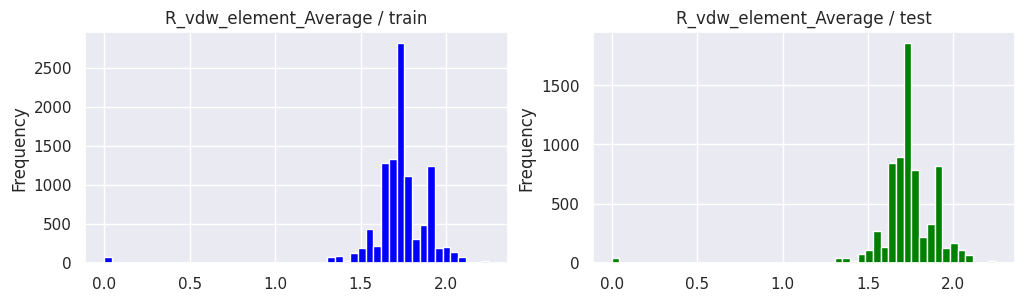

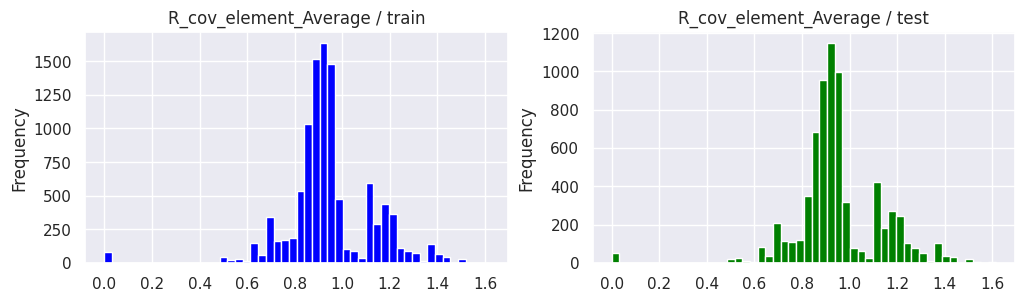

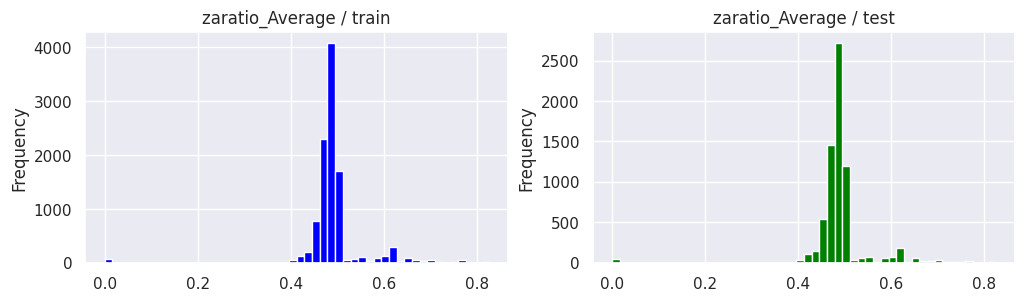

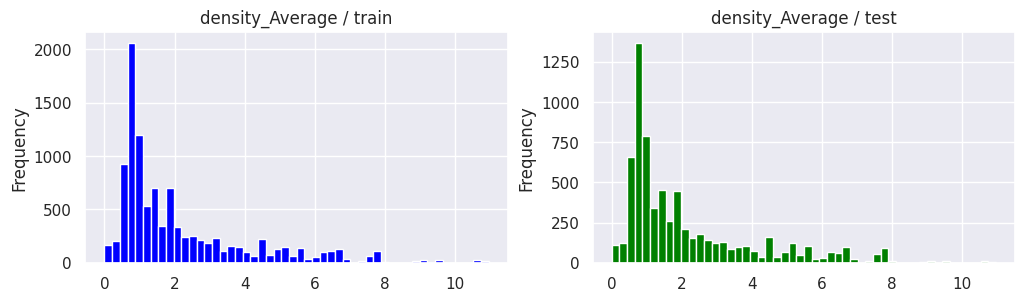

In [29]:
feature = train.columns.drop(['Hardness']).tolist() # 目的変数を指定する

for feat in feature:
    plt.figure(figsize=(12, 3))
    ax1 = plt.subplot(1, 2, 1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1, 2, 2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')
    
    plt.show()

#### データを対数変換する

array([[<Axes: title={'center': 'allelectrons_Total'}>,
        <Axes: title={'center': 'density_Total'}>,
        <Axes: title={'center': 'allelectrons_Average'}>],
       [<Axes: title={'center': 'val_e_Average'}>,
        <Axes: title={'center': 'atomicweight_Average'}>,
        <Axes: title={'center': 'ionenergy_Average'}>],
       [<Axes: title={'center': 'el_neg_chi_Average'}>,
        <Axes: title={'center': 'R_vdw_element_Average'}>,
        <Axes: title={'center': 'R_cov_element_Average'}>],
       [<Axes: title={'center': 'zaratio_Average'}>,
        <Axes: title={'center': 'density_Average'}>, <Axes: >]],
      dtype=object)

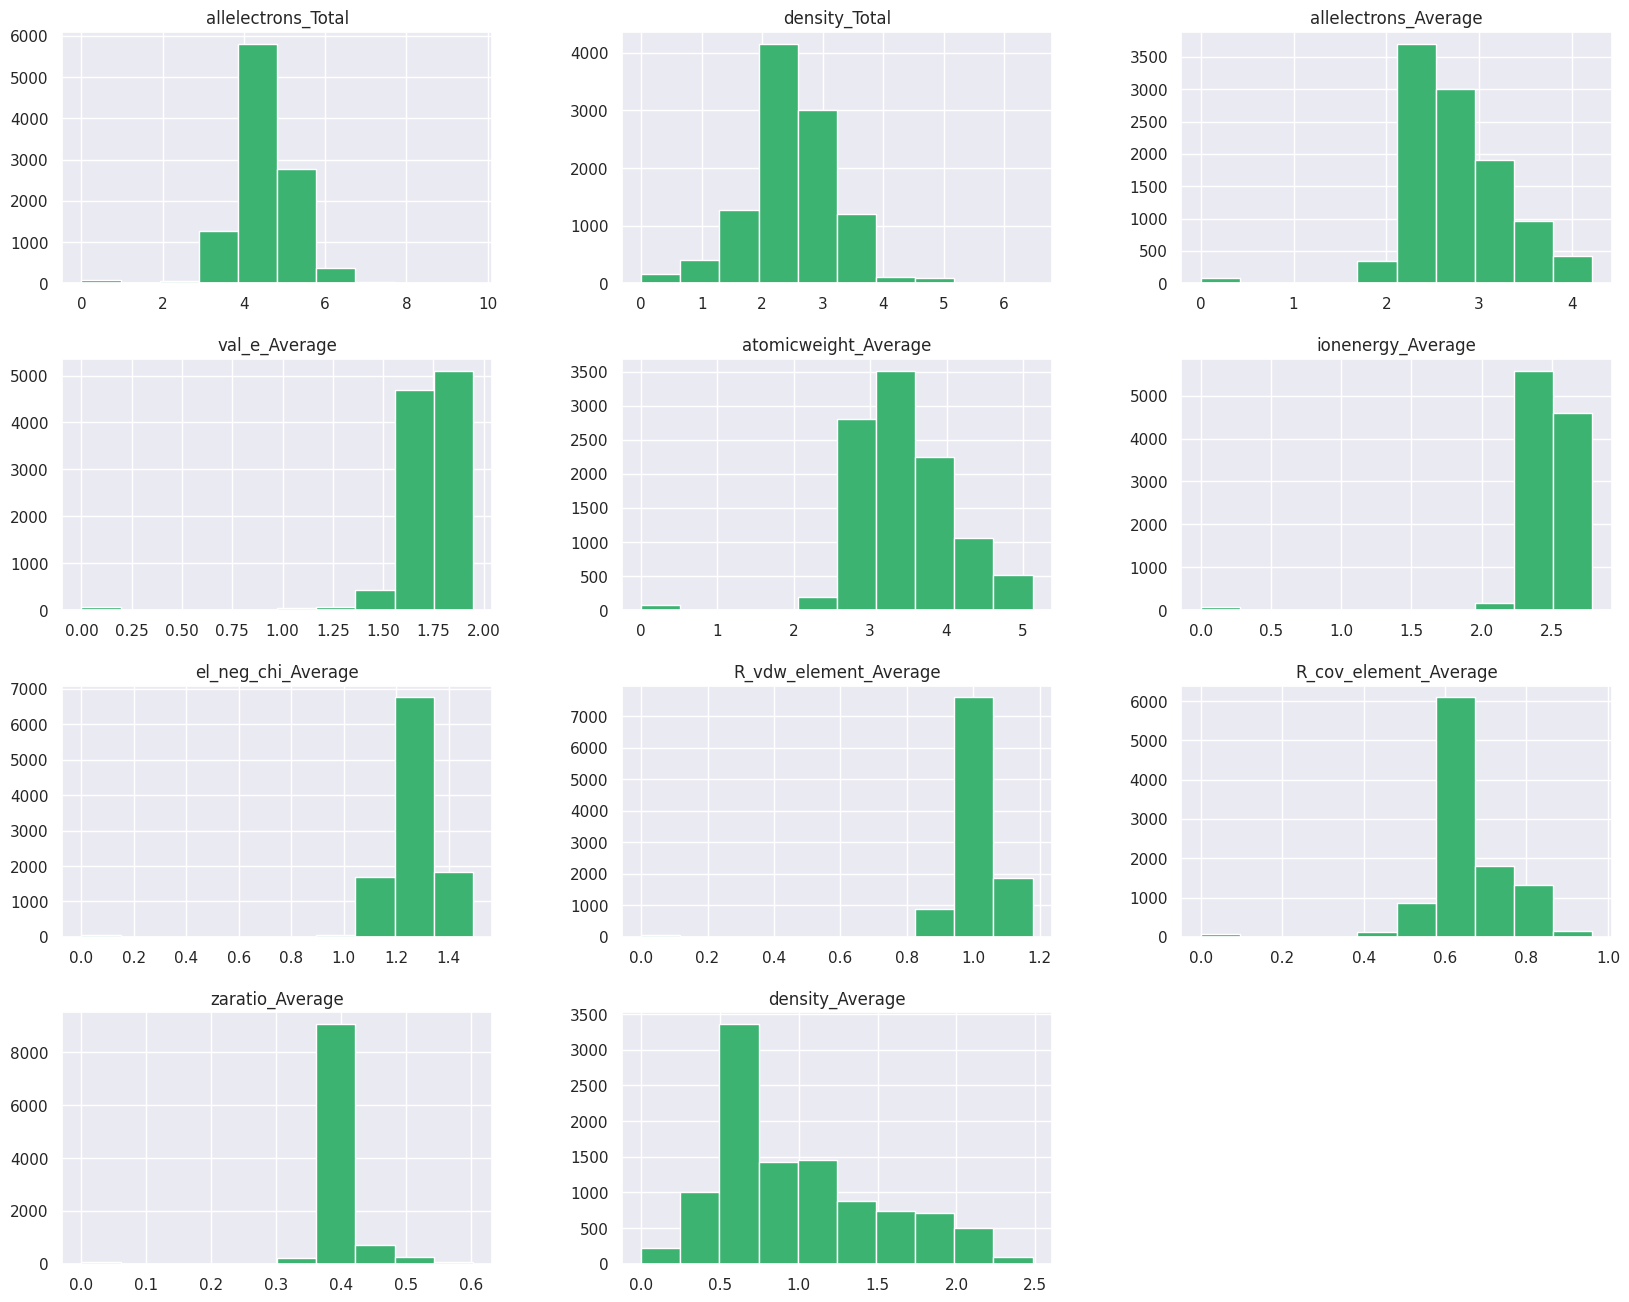

In [30]:
# 訓練データをX(説明変数)とy（目的変数）に分割する
X = train.drop(['Hardness'], axis=1) # 目的変数を指定する
y = train.Hardness # == target # 目的変数を指定する

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))

X.hist(color='mediumseagreen')

array([[<Axes: title={'center': 'allelectrons_Total'}>,
        <Axes: title={'center': 'density_Total'}>,
        <Axes: title={'center': 'allelectrons_Average'}>],
       [<Axes: title={'center': 'val_e_Average'}>,
        <Axes: title={'center': 'atomicweight_Average'}>,
        <Axes: title={'center': 'ionenergy_Average'}>],
       [<Axes: title={'center': 'el_neg_chi_Average'}>,
        <Axes: title={'center': 'R_vdw_element_Average'}>,
        <Axes: title={'center': 'R_cov_element_Average'}>],
       [<Axes: title={'center': 'zaratio_Average'}>,
        <Axes: title={'center': 'density_Average'}>, <Axes: >]],
      dtype=object)

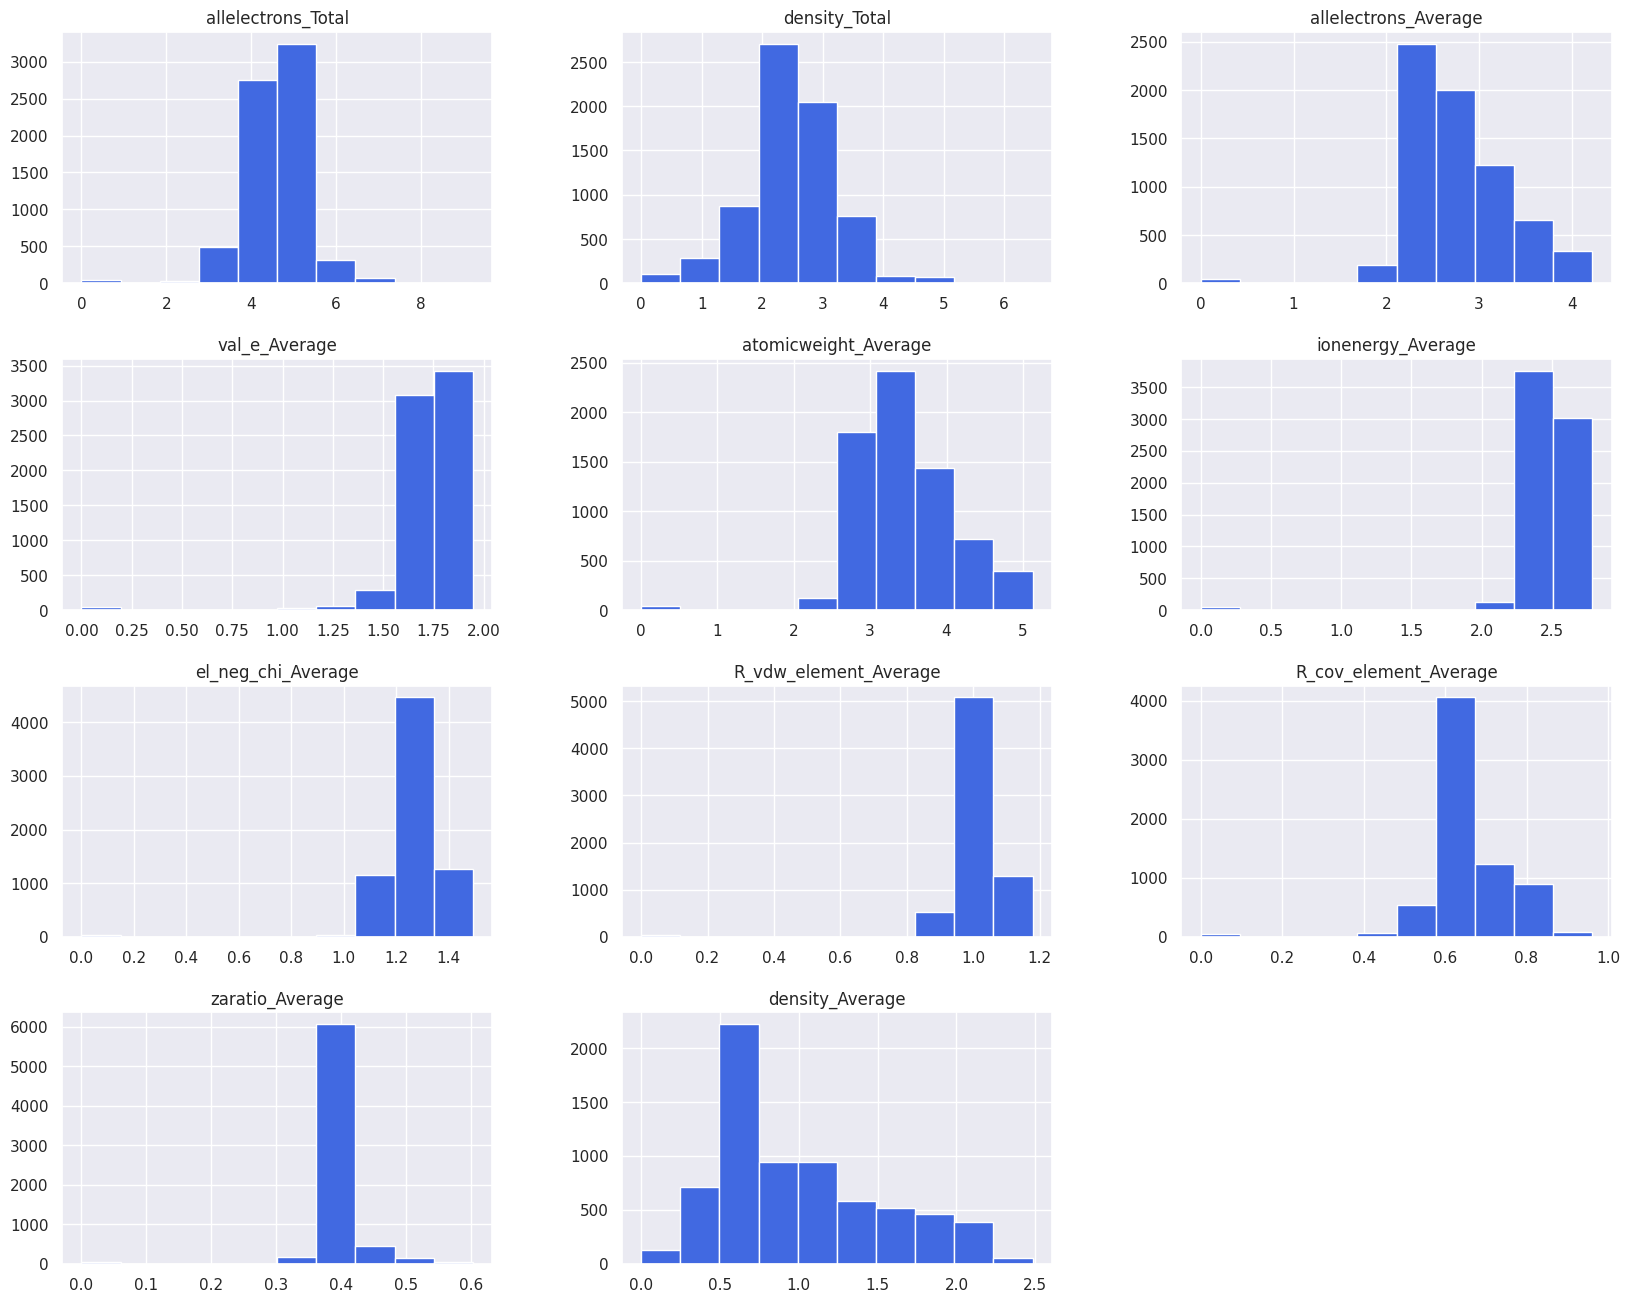

In [31]:
# テストデータも変換する
test_log = test
for column in test_log.columns.tolist():
    test_log[column] = test_log[column].apply(lambda x: np.log(x + 1))

test_log.hist(color='royalblue')

一部の説明変数において分布が確認しやすくなった

### 円グラフ：　目的変数（Hardness）

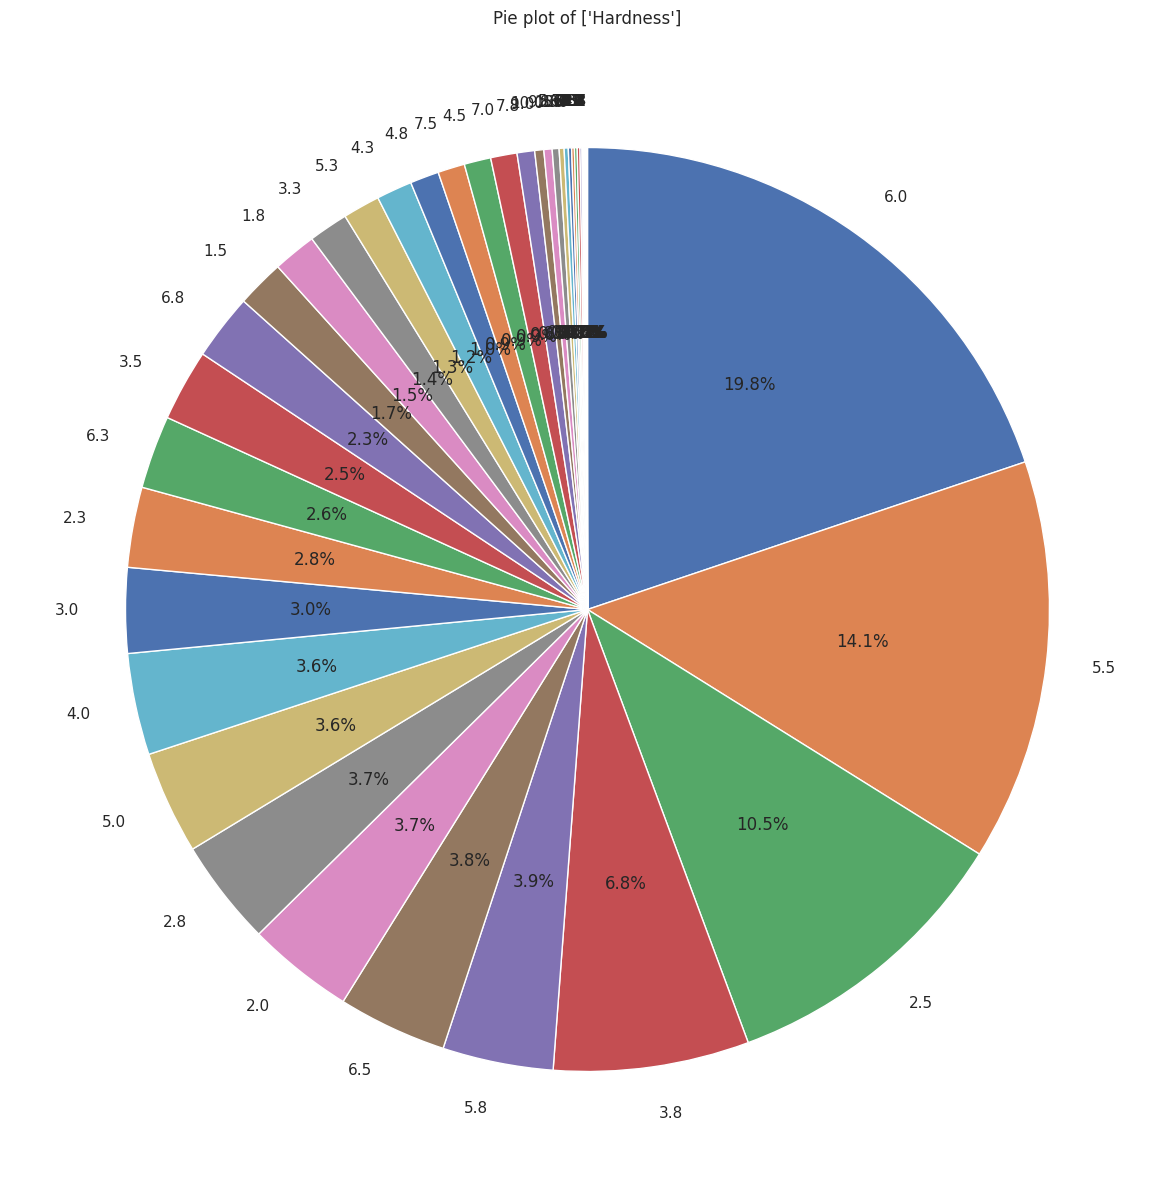

In [32]:
label_counts = target.value_counts()
# plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 15))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90,
        counterclock=False)
plt.title('Pie plot of ' + target_name)
plt.show()

### ヒストグラム（目的変数）

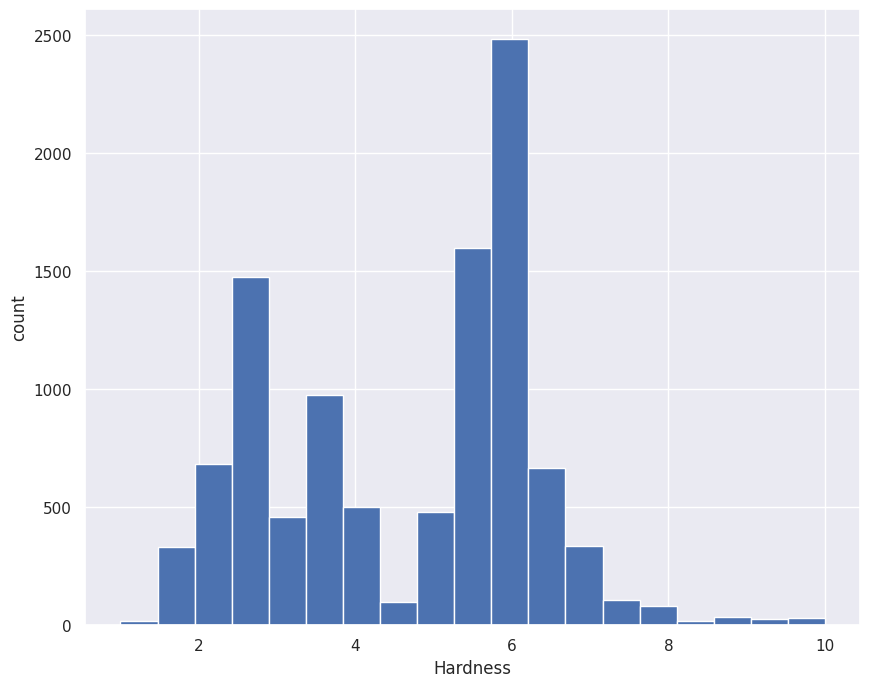

In [33]:
# 目的変数のどの数値が多いのか、少ないのか、偏りがあるのかを調べる
plt.figure(figsize=(10, 8))
plt.hist(target, bins=19, range=(1.0, 10.0))
plt.xlabel('Hardness')
plt.ylabel('count')
plt.grid(True)

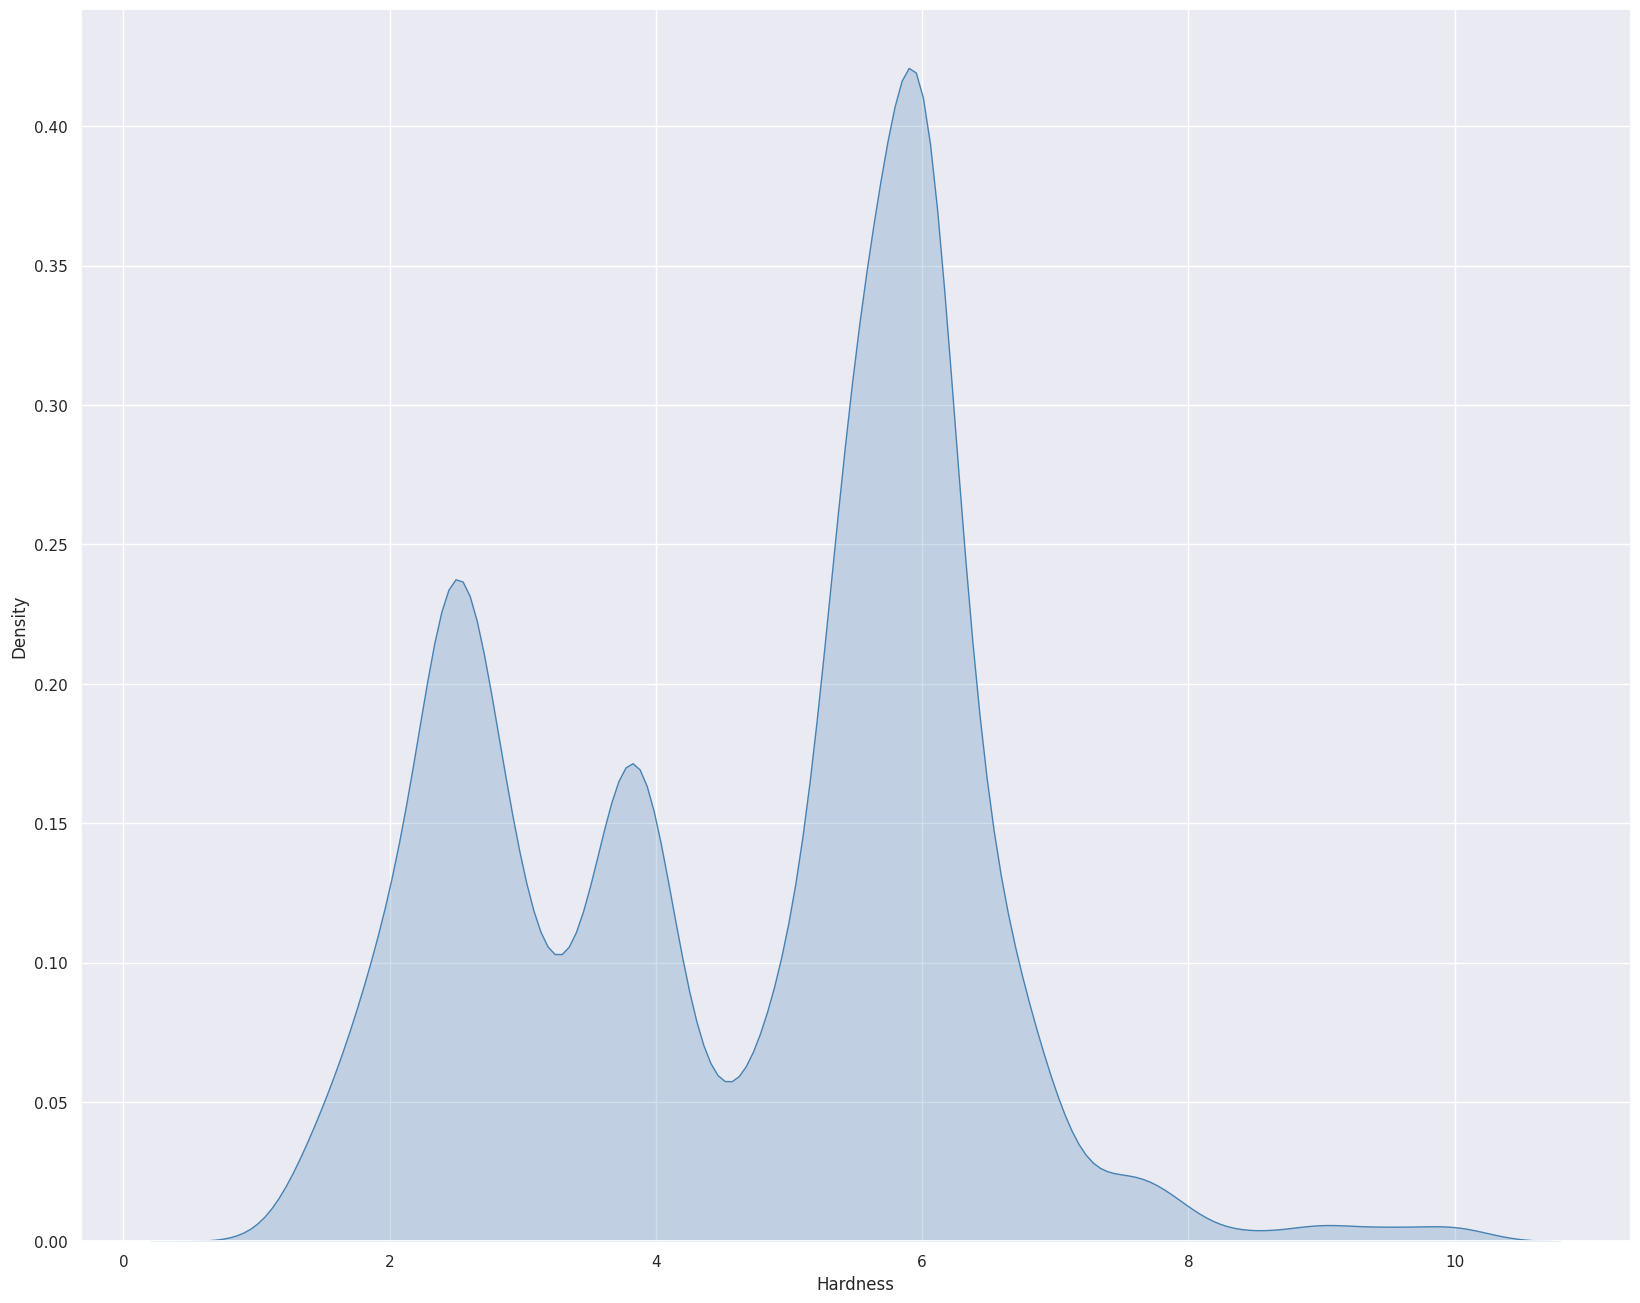

In [34]:
# 目的変数の可視化
sns.kdeplot(data=train, x='Hardness', fill=True, color='steelblue');

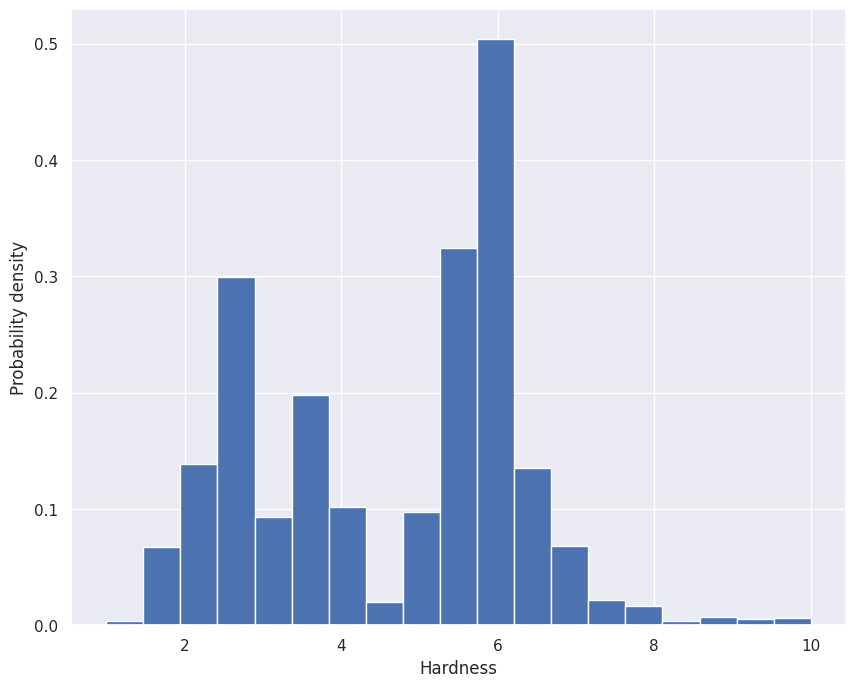

In [35]:
# 目的変数の値の分布を確率表現にする
plt.figure(figsize=(10, 8))
plt.hist(target, bins=19, density=True, range=(1.0, 10.0))
plt.xlabel('Hardness') # 目的変数を記述する
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

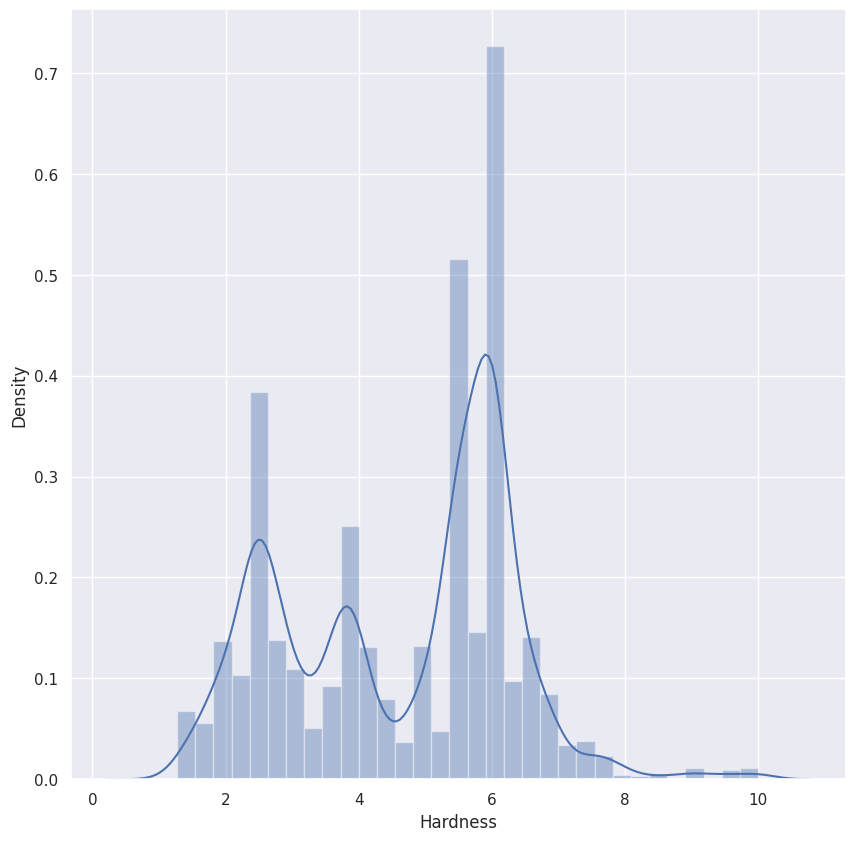

In [36]:
plt.figure(figsize=(10, 10))
sns.distplot(target)
plt.show()

mu = 4.65 and sigma = 1.68
※muは、中央値。 sigmaは、分散値


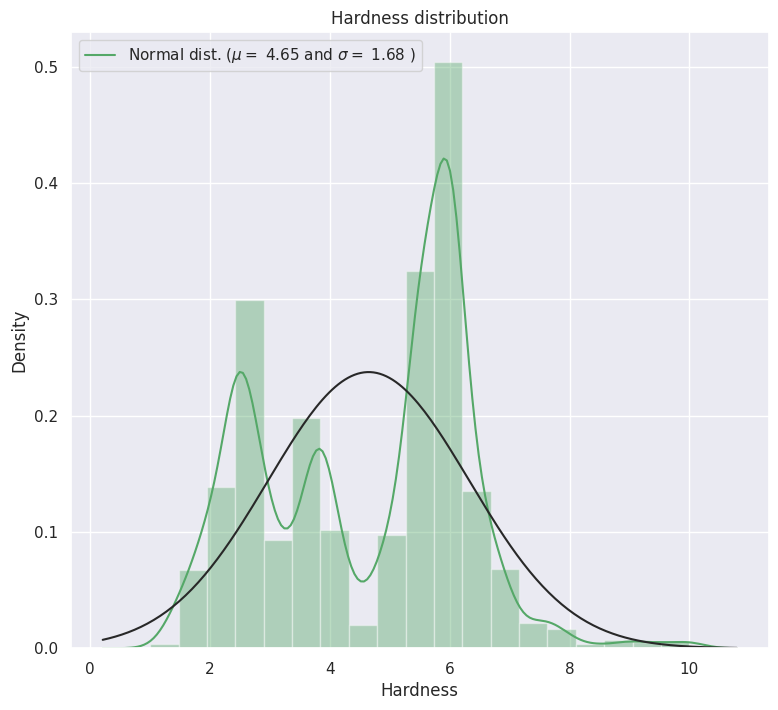

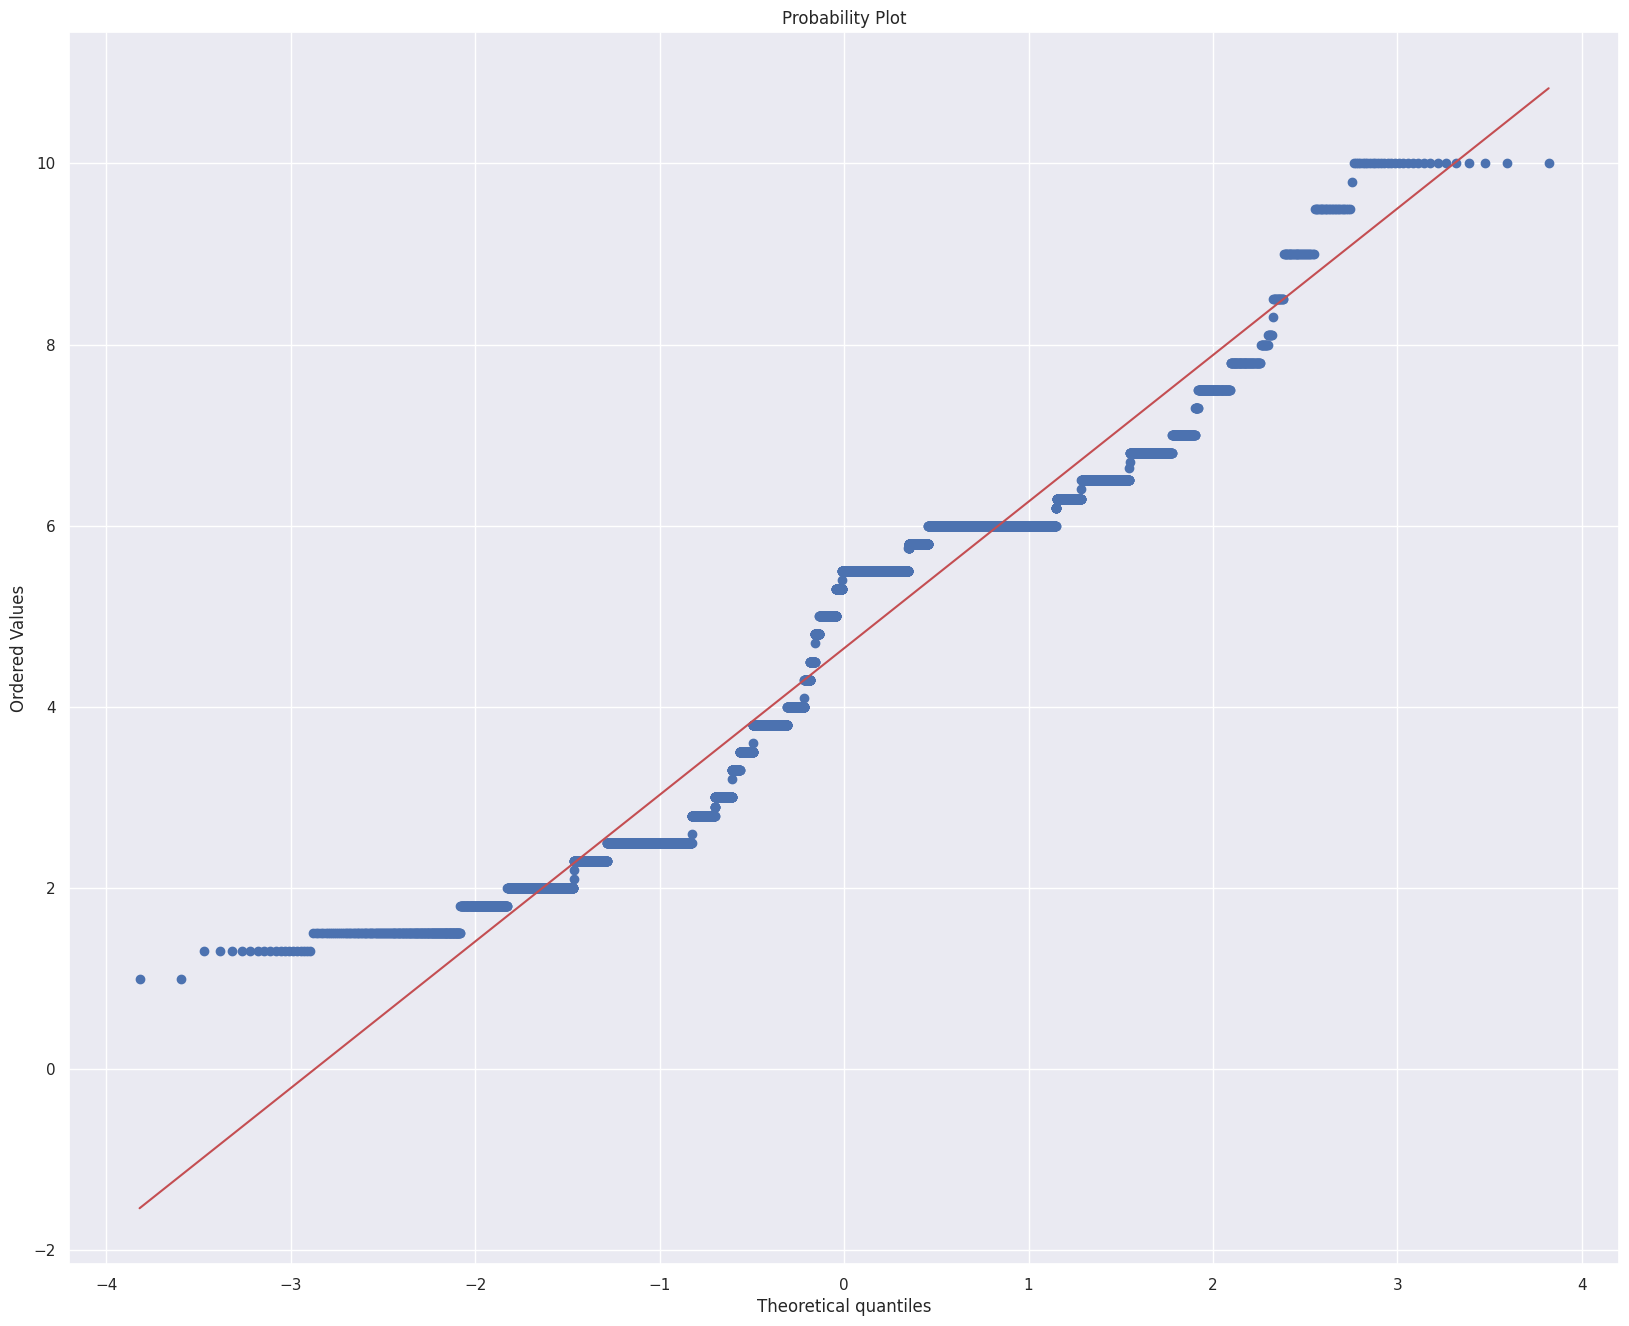

In [37]:
# 正規分布付きのヒストグラムを描画する
plt.figure(figsize=(9, 8))
sns.distplot(target, color='g', bins=19, hist_kws={'alpha': 0.4}, fit=norm);
# MLE(Maximum Likelihood Estimate)を用いて分布を推定する
(mu, sigma) = norm.fit(target)
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
print('※muは、中央値。 sigmaは、分散値')

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Density')
plt.title('Hardness distribution')

# QQプロットを描画する
# 正規QQプロットとは、観測値が正規分布に従う場合の期待値をY軸にとり、観測値そのものをX軸にとった確率プロット。
fig = plt.figure()
res = stats.probplot(target, plot=plt)
plt.show()

### 箱ひげ図

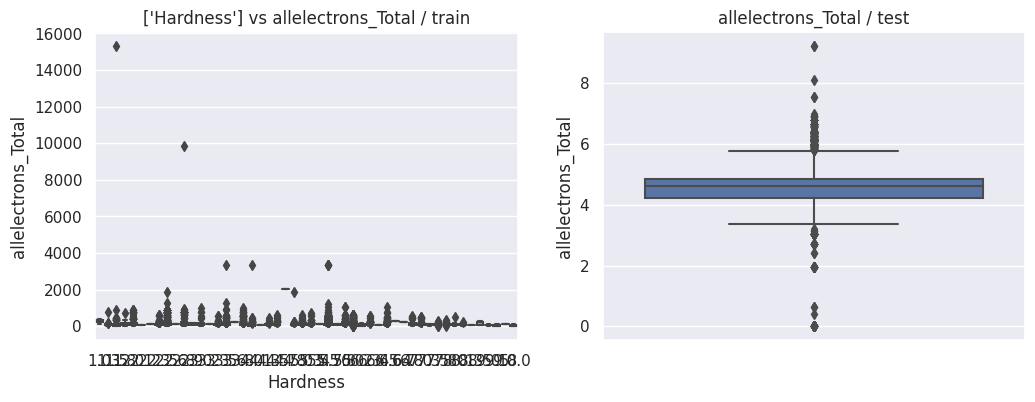

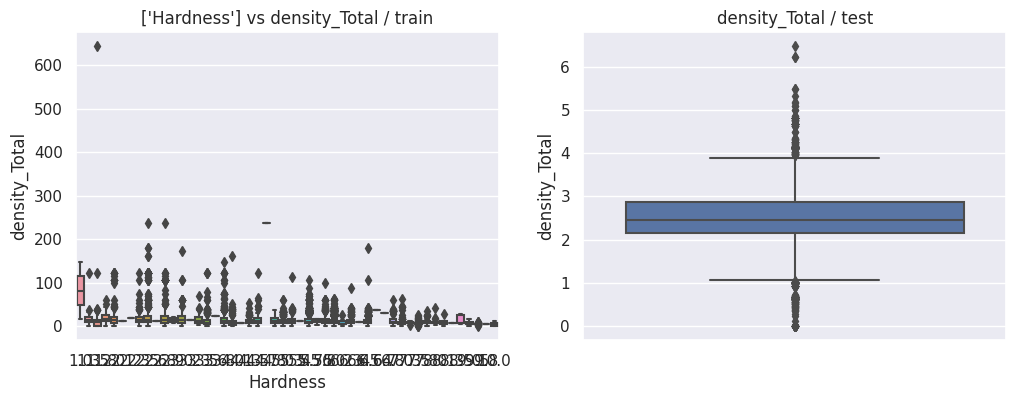

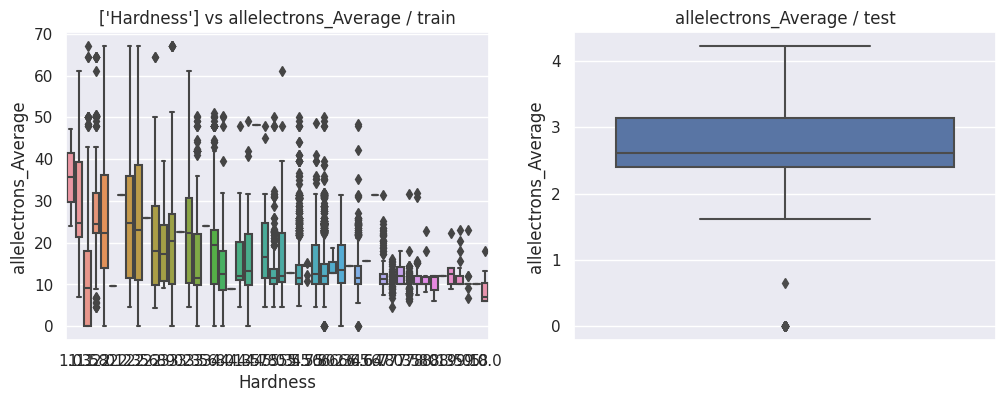

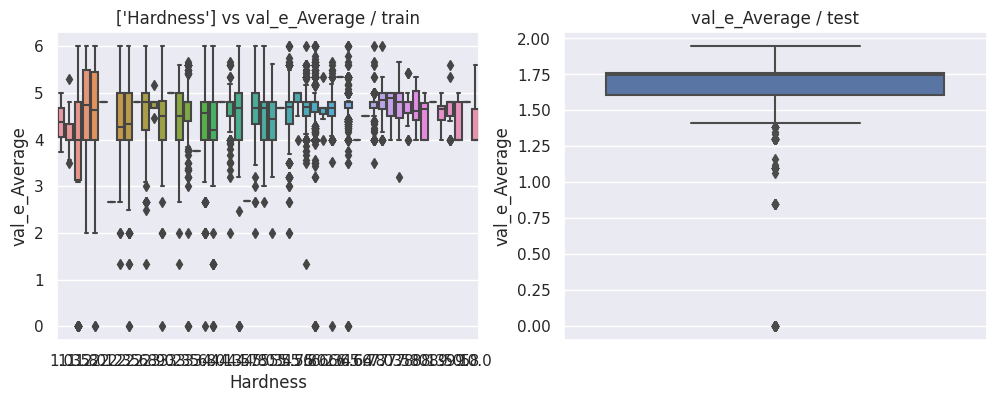

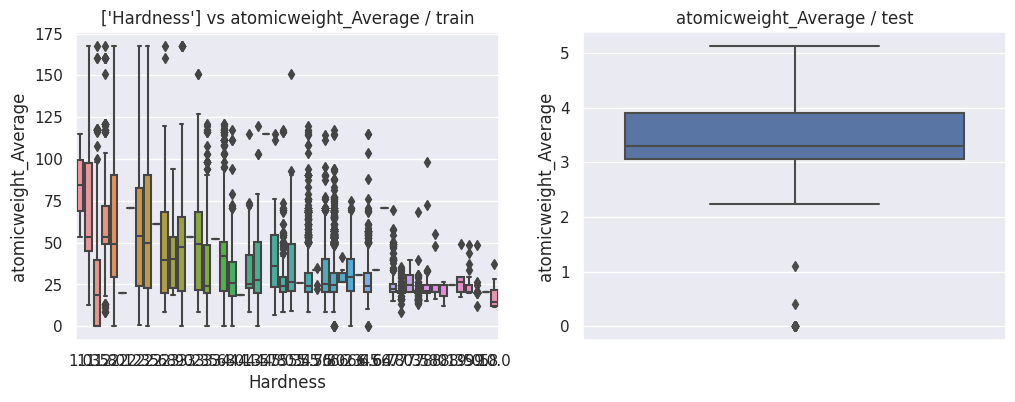

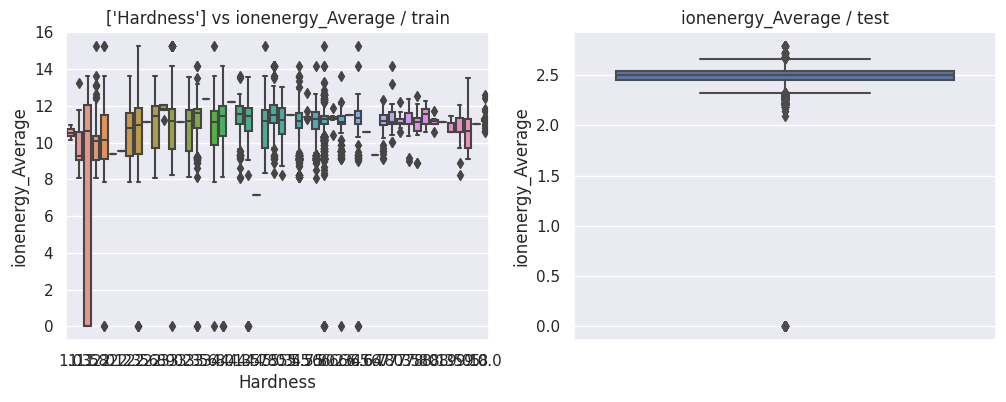

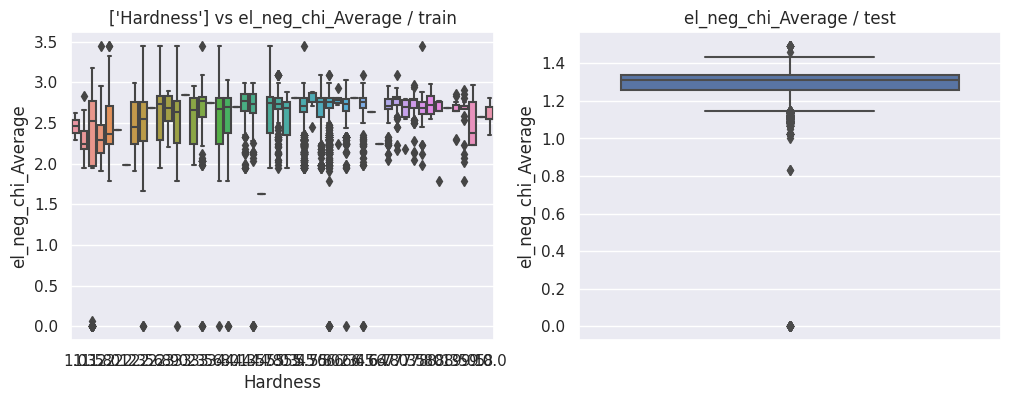

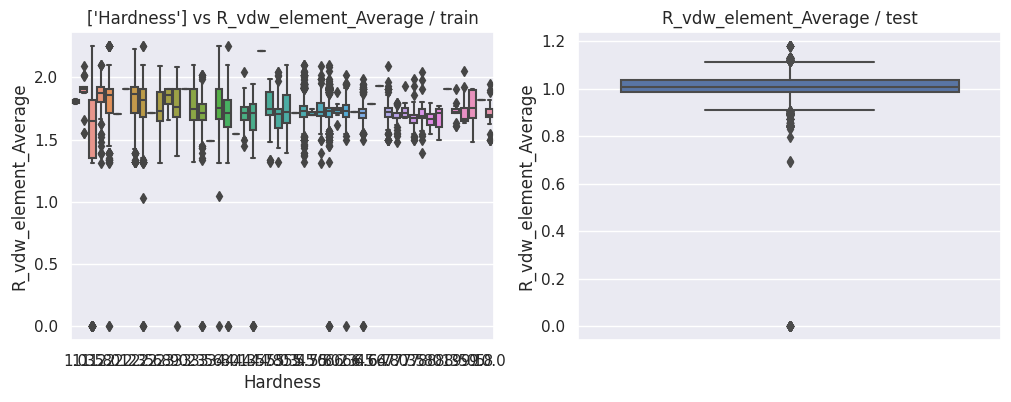

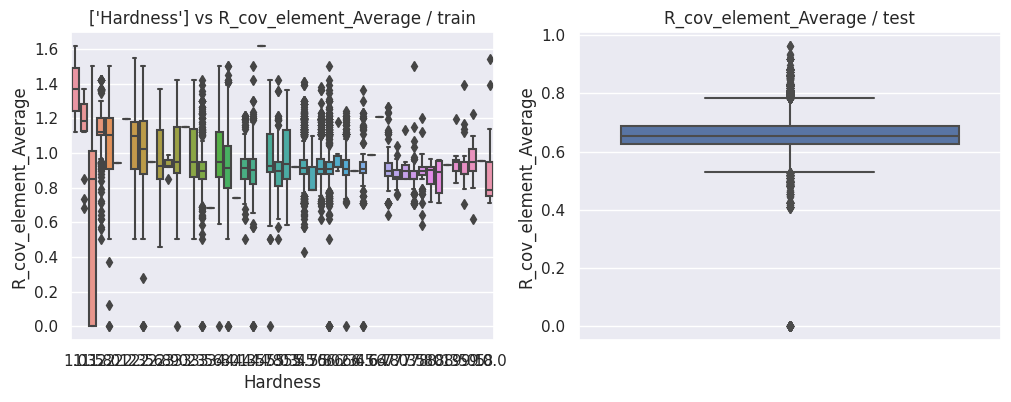

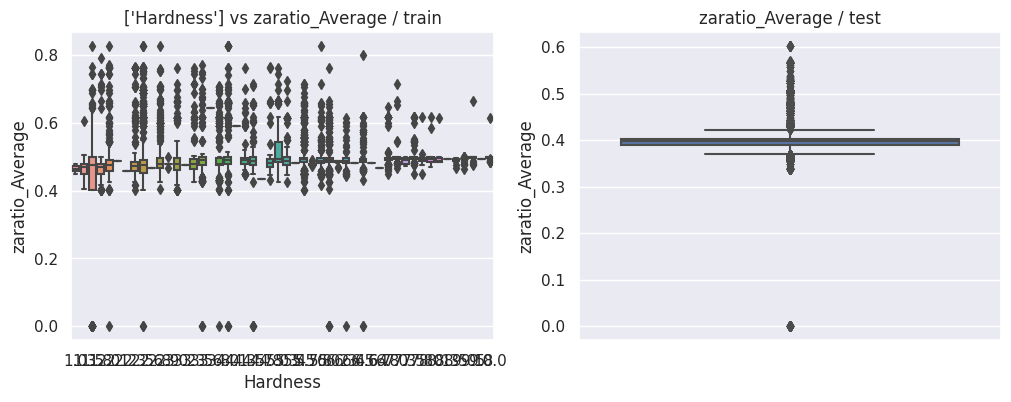

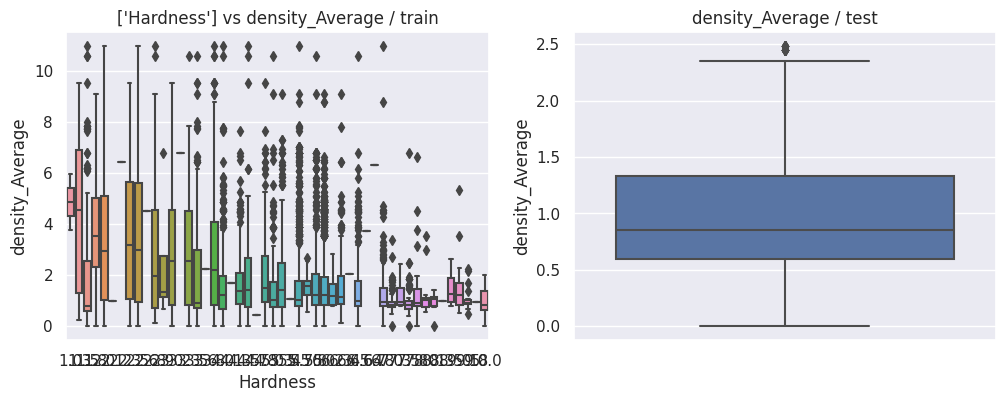

In [38]:
for feat in feature:
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=target, y=feat)
    plt.title(target_name + ' vs ' + feat + ' / train')
    x1 = plt.subplot(1, 2, 2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

#### 箱ひげ図（目的変数）

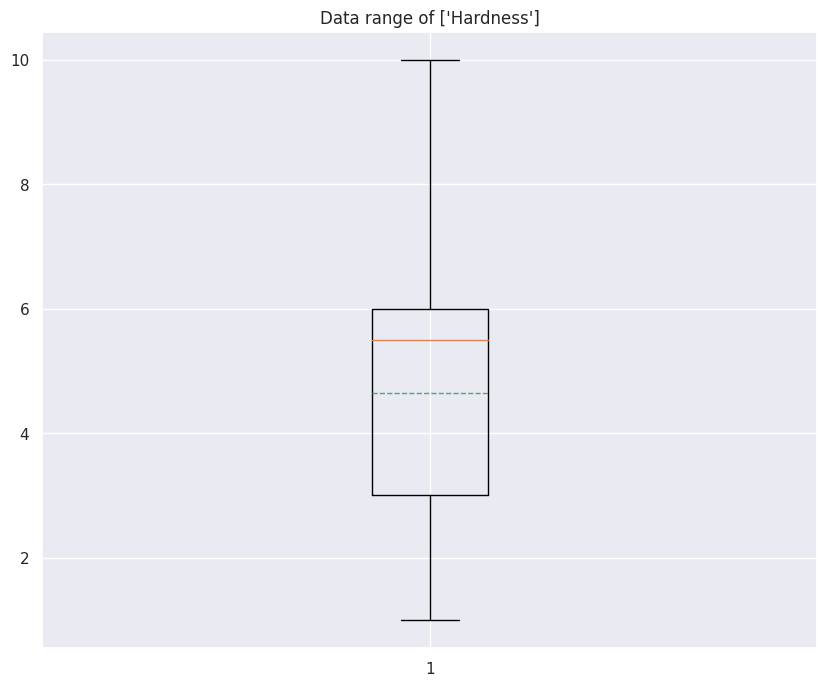

In [39]:
# データの範囲を調べる
plt.figure(figsize=(10, 8))
plt.boxplot(target, showmeans=True, meanline=True)
plt.title('Data range of ' + target_name)
plt.grid(True)

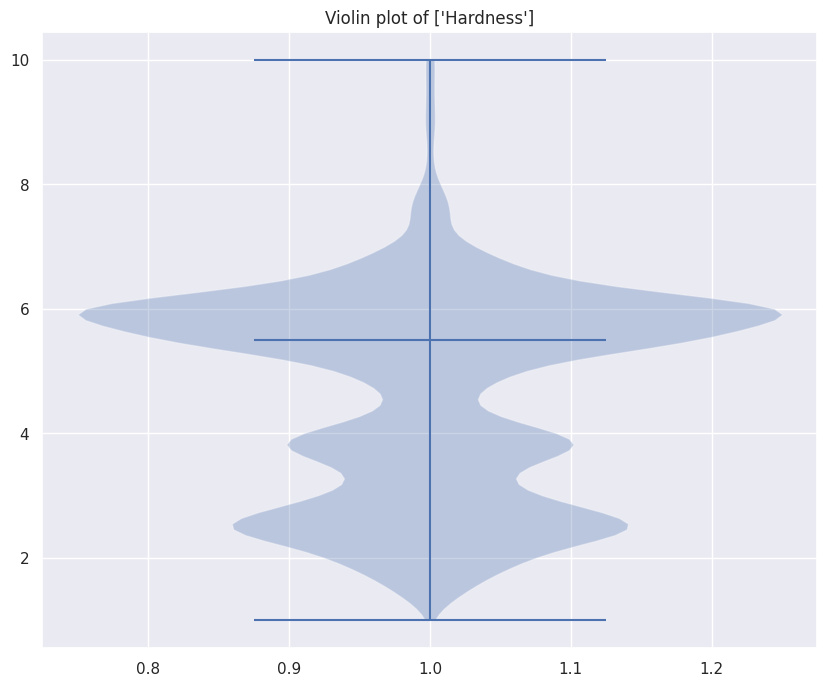

In [40]:
# バイオリンプロット
plt.figure(figsize=(10, 8))
plt.violinplot(target, showmedians=True) # 中央値をマーキングする
plt.title('Violin plot of ' + target_name)
plt.grid(True)

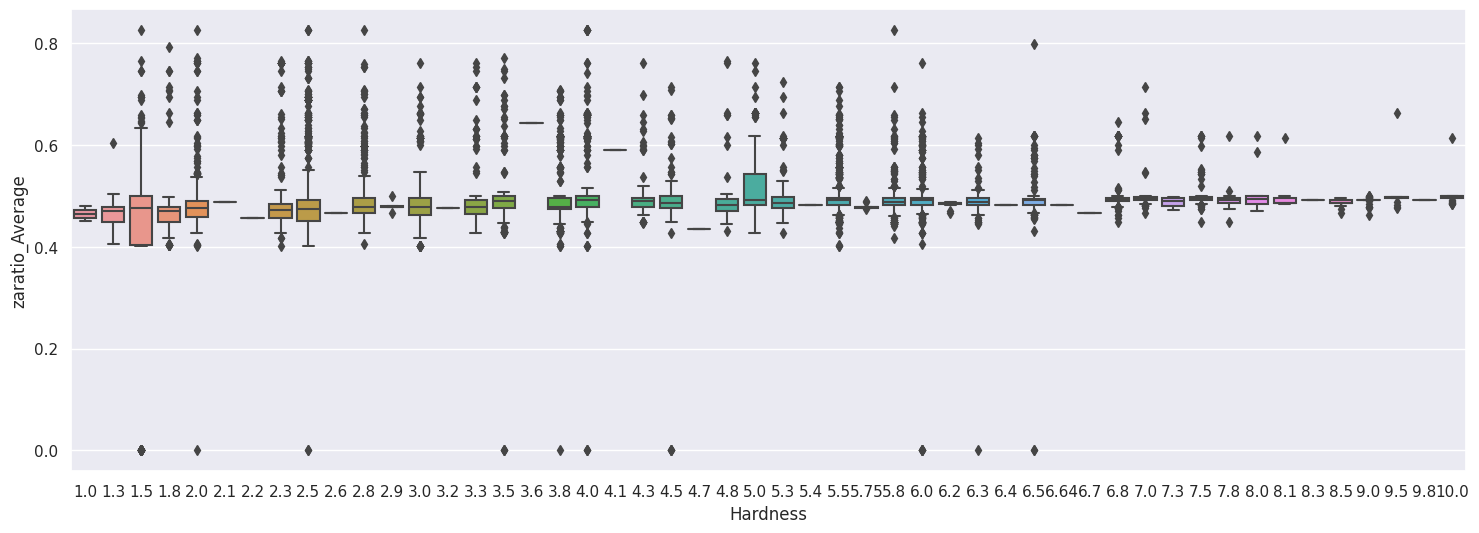

In [41]:
# 目的変数と'zaratio_Average'（最も特徴重要度の高い説明変数）との関係
train_zaratio_Average = 'zaratio_Average'
categorical_variate_corr = pd.concat([target, train[train_zaratio_Average]], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x=target, y=train_zaratio_Average, data=categorical_variate_corr)
fig.axis();

In [42]:
df_melted = pd.melt(train.select_dtypes(include=['float', 'int']))

custom_colors = px.colors.qualitative.Plotly

fig = px.box(df_melted, x='variable', y='value', color='variable', color_discrete_sequence=custom_colors)
fig.update_layout(title='Box Plots')
fig.show()

### 特徴量の重要度評価

CPU times: user 8.41 s, sys: 59.2 ms, total: 8.47 s
Wall time: 8.42 s


<Axes: >

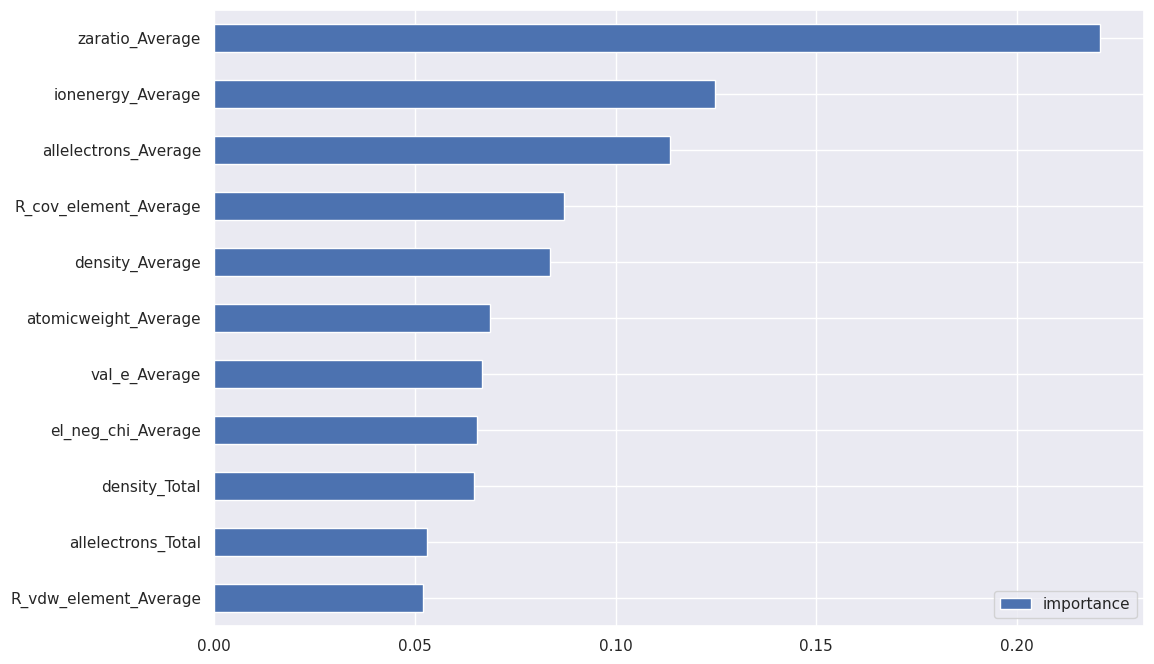

In [43]:
%%time

best_forest = RandomForestRegressor(
    random_state=42,
)

best_forest.fit(X, y)
importance = best_forest.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(12, 8), color='b')

* 'zaratio_Average'が重要度が特に高い
* 'R_vdw_element_Average'だけが平均値カラムで低い

### 相関（ヒートマップ）

<Axes: >

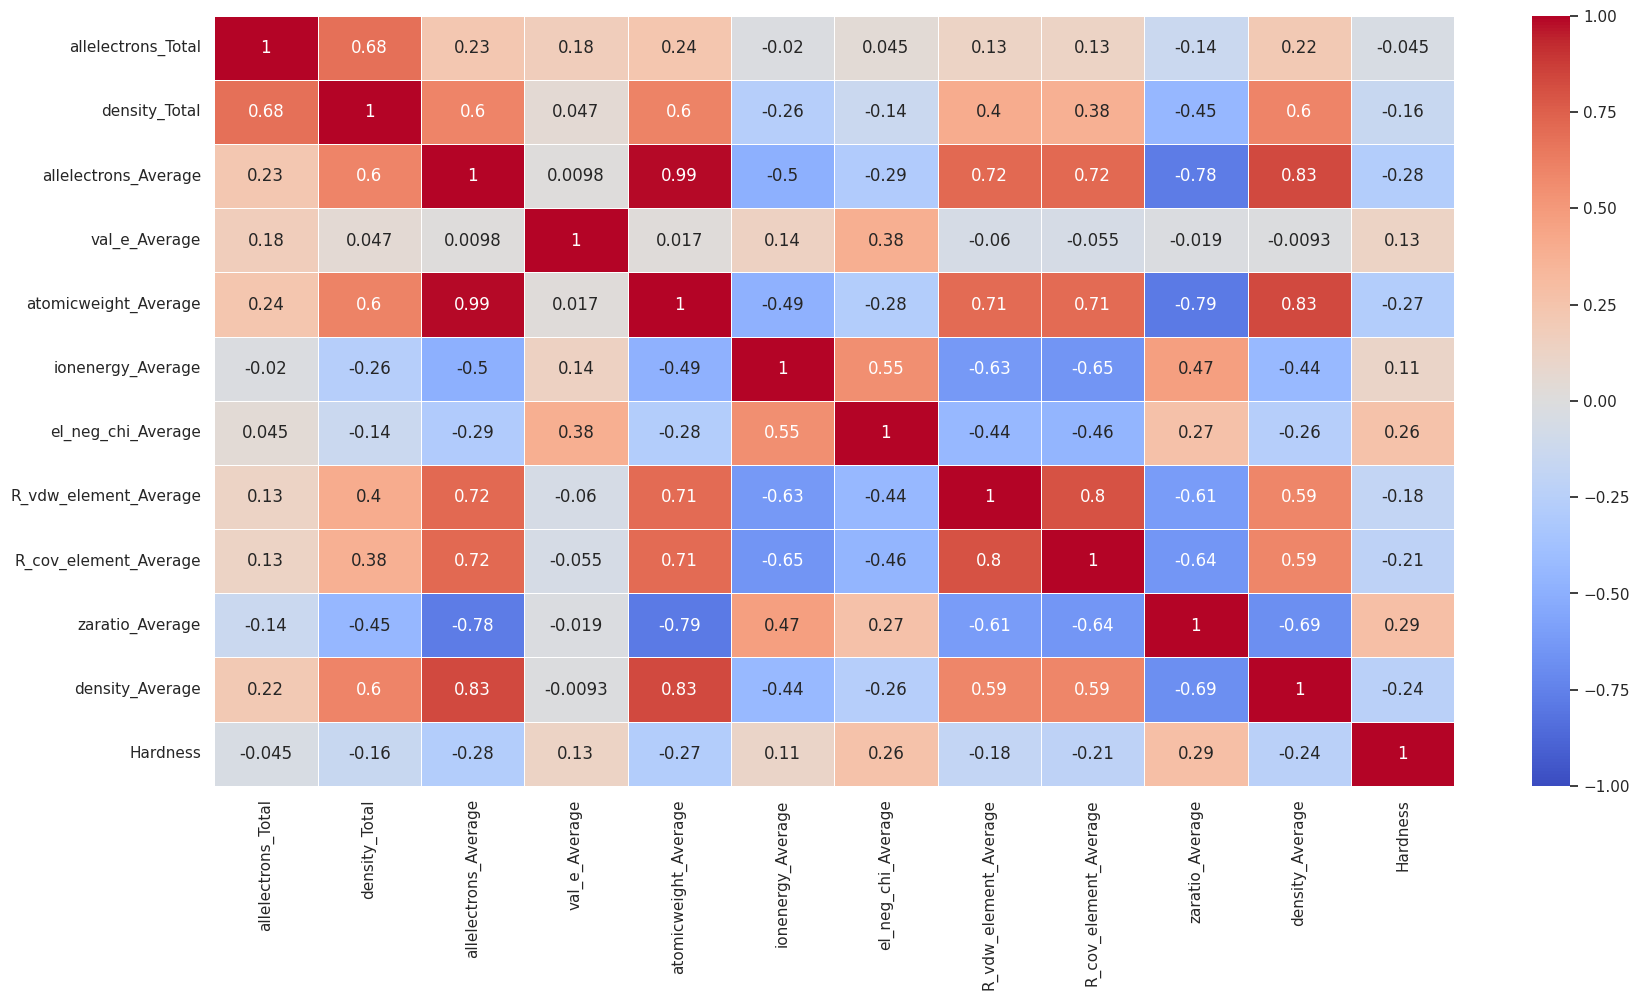

In [44]:
corr = train.corr(method='spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(corr, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

In [45]:
# 対数変換後の相関係数
correlation = X.corr()
correlation.style.background_gradient(cmap='coolwarm')

* 'allelectrons_Average'と'atomicweight_Average'の間には強い相関がある（99%の相関）

#### 相関(目的変数)

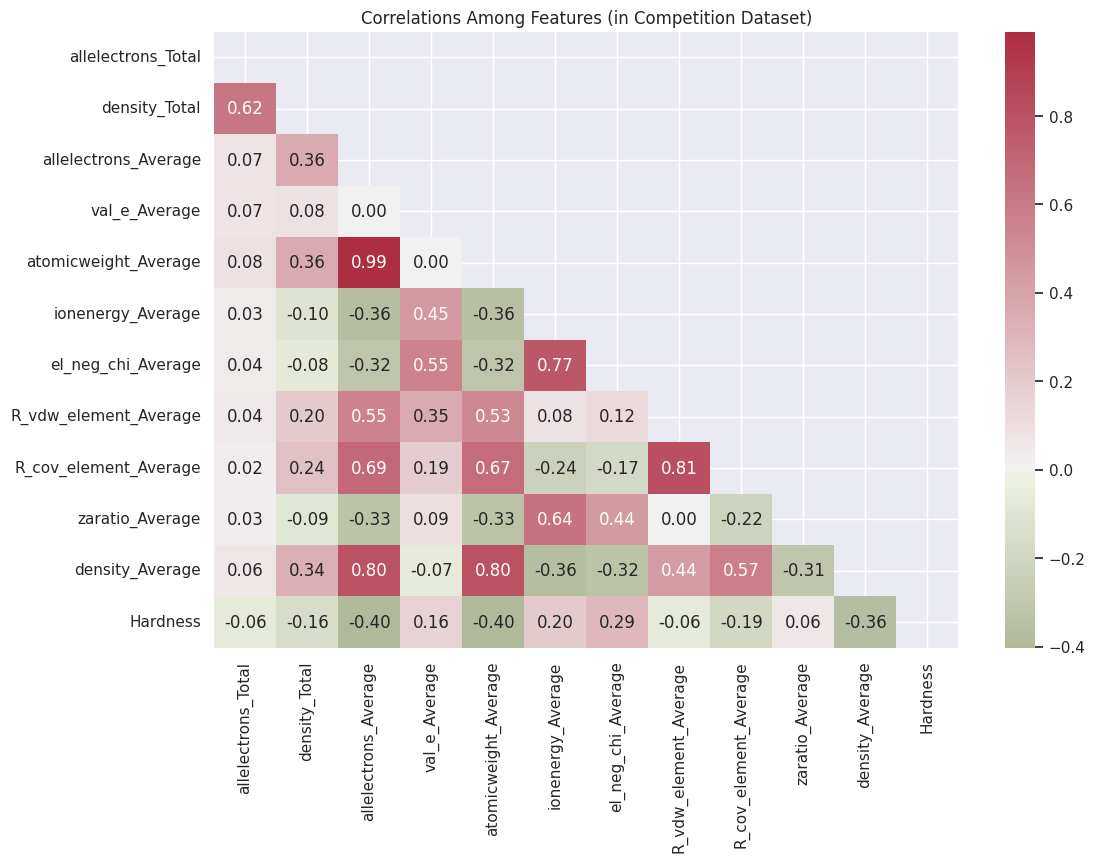

In [46]:
corr_mat_data = train.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center='light', as_cmap=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
            annot_kws={'size': 12}, mask=data_mask).set_title('Correlations Among Features (in Competition Dataset)');

* R_cov_element_Average と R_vdw_element_Averageは81％の相関
* density_Average は allelectrons_Average と atomicweight_Average との間で強い相関がある（80%の相関）
* allelectrons_Average が Hardness との間で（絶対値で）最も高い相関を持つ

In [47]:
# 目的変数との相関の値が高い順に表示する
corr_target_data = train.corr()['Hardness'] # 目的変数を指定する
corr_target_data.sort_values(ascending=False)

Hardness                 1.000000
el_neg_chi_Average       0.290352
ionenergy_Average        0.203203
val_e_Average            0.161715
zaratio_Average          0.055248
R_vdw_element_Average   -0.061402
allelectrons_Total      -0.061687
density_Total           -0.161524
R_cov_element_Average   -0.189111
density_Average         -0.360780
allelectrons_Average    -0.400496
atomicweight_Average    -0.402948
Name: Hardness, dtype: float64

#### 散布図

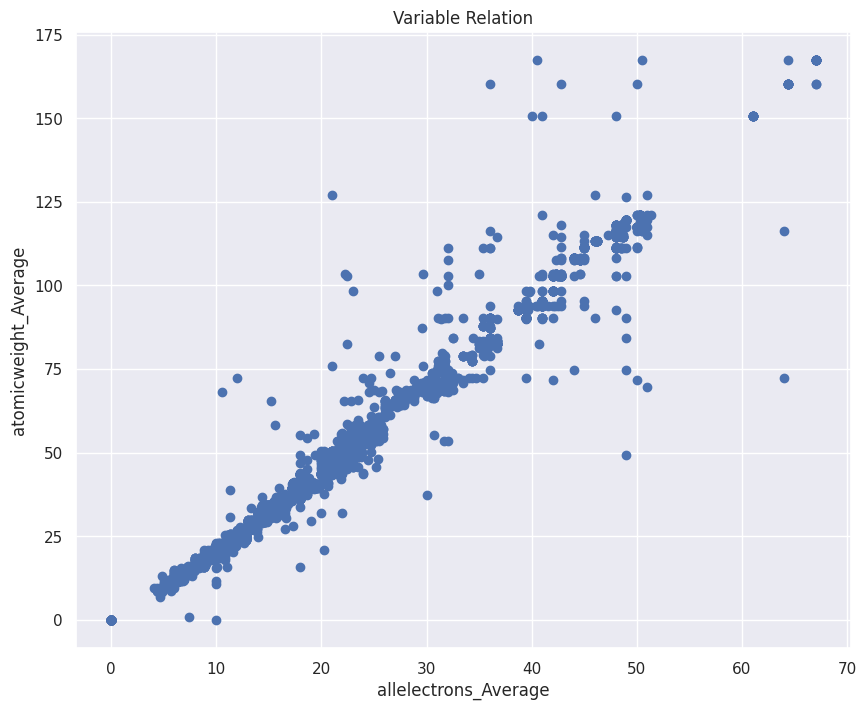

In [48]:
# ヒートマップの結果から、散布図で変数の関係性を調べる
train_allelectrons_Average = train['allelectrons_Average']
train_atomicweight_Average = train['atomicweight_Average']

plt.figure(figsize=(10, 8))

plt.scatter(train_allelectrons_Average, train_atomicweight_Average)
plt.title('Variable Relation')
plt.xlabel('allelectrons_Average')
plt.ylabel('atomicweight_Average')
plt.grid(True)

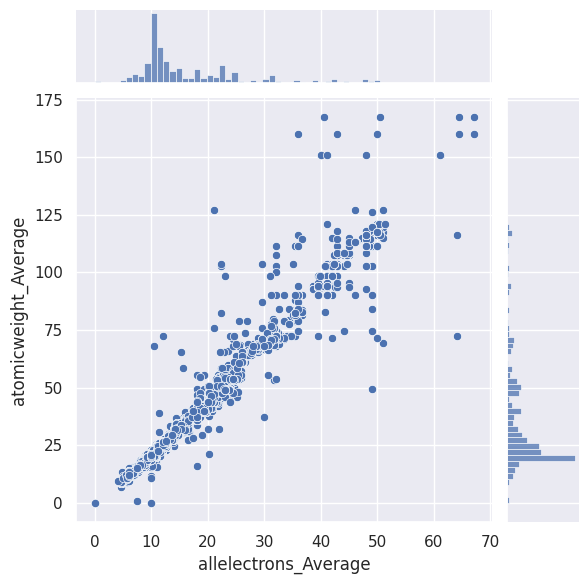

In [49]:
# 二変量グラフと単変量グラフを作成する
sns.jointplot(x=train_allelectrons_Average, y=train_atomicweight_Average, data=train)

#### 高い相関を持つ説明変数の散布図

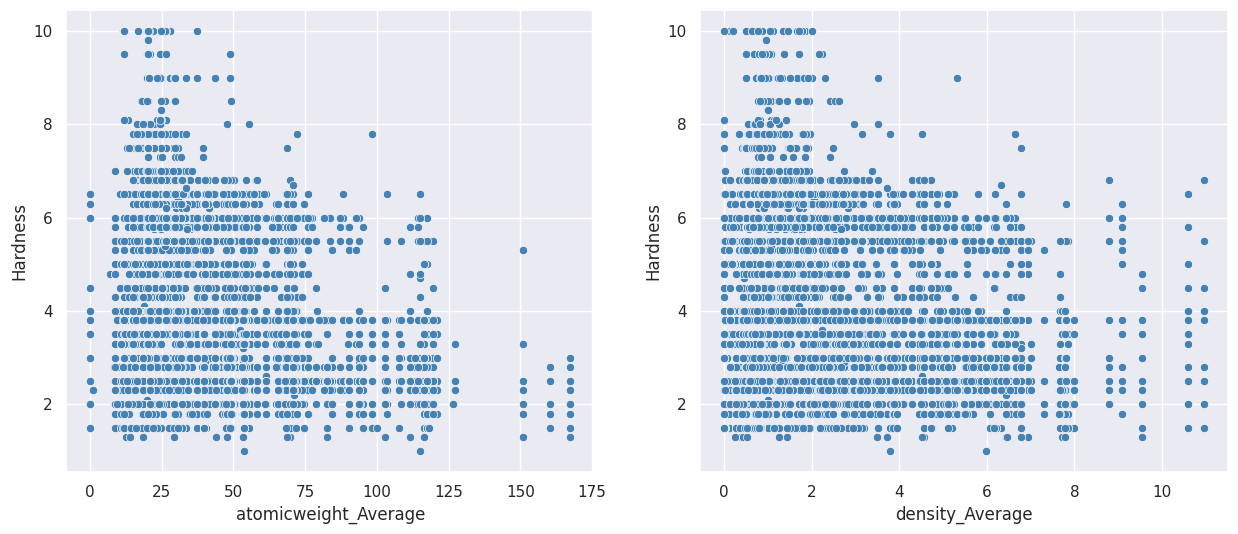

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(ax=axes[0], data=train, x='atomicweight_Average', y='Hardness', color='steelblue')
sns.scatterplot(ax=axes[1], data=train, x='density_Average', y='Hardness', color='steelblue');

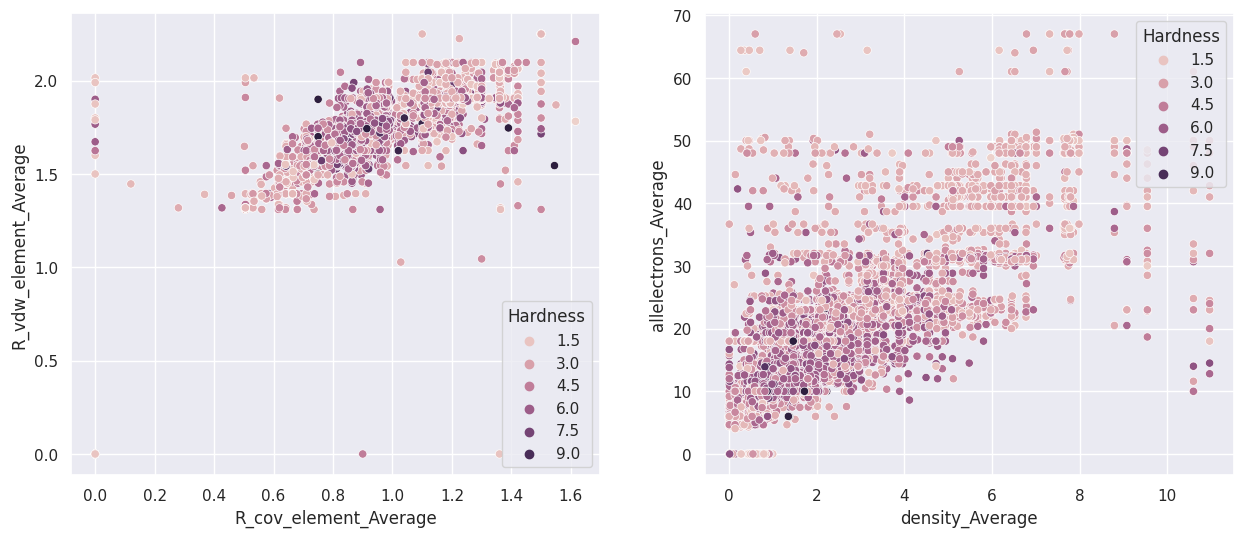

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(ax=axes[0], data=train, x='R_cov_element_Average', y='R_vdw_element_Average', hue='Hardness')
sns.scatterplot(ax=axes[1], data=train, x='density_Average', y='allelectrons_Average', hue='Hardness');

* 右のグラフでは、プロットの上半分（allelectrosn_Average > 40）で、硬度（Hardness）が4.5以下

## 目的変数（Hardness）

In [52]:
# 目的変数（Hardness）を数える
print(f'{train.Hardness.value_counts()}\n\n')

Hardness
6.00     2063
5.50     1463
2.50     1089
3.80      712
5.80      403
6.50      397
2.00      388
2.80      387
5.00      375
4.00      370
3.00      310
2.30      292
6.30      266
3.50      261
6.80      240
1.50      174
1.80      158
3.30      144
5.30      135
4.30      130
4.80      105
7.50       98
4.50       97
7.00       96
7.80       64
9.00       33
10.00      30
9.50       25
1.30       18
8.50       15
8.00       12
5.75       10
6.20       10
7.30       10
8.10        7
2.90        5
1.00        2
2.20        1
5.40        1
6.70        1
2.60        1
3.60        1
8.30        1
4.10        1
3.20        1
4.70        1
6.40        1
9.80        1
2.10        1
6.64        1
Name: count, dtype: int64




In [53]:
print(train.Hardness.value_counts() / train.shape[0]) # 値の相対的な出現頻度

Hardness
6.00     0.198232
5.50     0.140578
2.50     0.104641
3.80     0.068415
5.80     0.038724
6.50     0.038147
2.00     0.037283
2.80     0.037187
5.00     0.036033
4.00     0.035553
3.00     0.029788
2.30     0.028058
6.30     0.025560
3.50     0.025079
6.80     0.023061
1.50     0.016720
1.80     0.015182
3.30     0.013837
5.30     0.012972
4.30     0.012492
4.80     0.010089
7.50     0.009417
4.50     0.009321
7.00     0.009225
7.80     0.006150
9.00     0.003171
10.00    0.002883
9.50     0.002402
1.30     0.001730
8.50     0.001441
8.00     0.001153
5.75     0.000961
6.20     0.000961
7.30     0.000961
8.10     0.000673
2.90     0.000480
1.00     0.000192
2.20     0.000096
5.40     0.000096
6.70     0.000096
2.60     0.000096
3.60     0.000096
8.30     0.000096
4.10     0.000096
3.20     0.000096
4.70     0.000096
6.40     0.000096
9.80     0.000096
2.10     0.000096
6.64     0.000096
Name: count, dtype: float64


In [54]:
train.groupby('Hardness')['zaratio_Average'].mean() # Hardness(目的変数)を軸として、zaratio_Averageの平均値を算出する

Hardness
1.00     0.465022
1.30     0.472269
1.50     0.396917
1.80     0.474793
2.00     0.487165
2.10     0.487610
2.20     0.456803
2.30     0.496471
2.50     0.492941
2.60     0.467304
2.80     0.500574
2.90     0.480499
3.00     0.489629
3.20     0.476712
3.30     0.501193
3.50     0.494016
3.60     0.643744
3.80     0.495216
4.00     0.515155
4.10     0.590040
4.30     0.497986
4.50     0.486672
4.70     0.434283
4.80     0.491505
5.00     0.520081
5.30     0.502845
5.40     0.482157
5.50     0.496032
5.75     0.479623
5.80     0.493859
6.00     0.490245
6.20     0.482378
6.30     0.487820
6.40     0.482467
6.50     0.491094
6.64     0.481969
6.70     0.466061
6.80     0.499044
7.00     0.500669
7.30     0.487467
7.50     0.504653
7.80     0.492413
8.00     0.507629
8.10     0.507108
8.30     0.492736
8.50     0.486447
9.00     0.490979
9.50     0.502058
9.80     0.492820
10.00    0.500435
Name: zaratio_Average, dtype: float64

### データの抽出

In [55]:
train[train['Hardness'] == 6.0] # 条件（フィルター）

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
0                   100.0       0.841611             10.000000       4.800000   
3                   100.0       8.795296             10.000000       4.800000   
4                   116.0       9.577996             11.600000       4.800000   
5                   131.0      24.529328             21.833333       4.666667   
8                   120.0      14.632000             12.000000       4.800000   
...                   ...            ...                   ...            ...   
10366               198.0       7.558488              7.600000       3.200000   
10381               114.0       8.426660             14.500000       4.000000   
10391               118.0      13.955818             13.600000       4.800000   
10396                62.0       8.337992             12.600000       4.800000   
10405                38.0       1.553160             12.666667       4.666667   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0                 20.612526          11.088100            2.766000   
3                 20.213349          10.948500            2.648000   
4                 24.988133          11.824480            2.766000   
5                 50.131500          11.948200            2.858333   
8                 24.808518          11.331820            2.870000   
...                     ...                ...                 ...   
10366             14.996860          12.415840            2.550000   
10381             31.574636          10.759120            2.684000   
10391             29.568292          11.023840            2.675000   
10396             26.385218          11.116960            2.684000   
10405             26.621687          11.290033            2.743333   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                   1.732000               0.860000         0.496070   
3                   1.626000               0.936000         0.489272   
4                   1.682000               0.896000         0.492736   
5                   1.758333               0.896667         0.466388   
8                   1.718500               0.910000         0.492736   
...                      ...                    ...              ...   
10366               1.551000               0.710000         0.617395   
10381               1.732000               0.914000         0.482036   
10391               1.726000               0.928000         0.482036   
10396               1.680000               0.824000         0.498666   
10405               1.756667               0.980000         0.486507   

       density_Average  Hardness  
0              0.91457       6.0  
3              0.78937       6.0  
4              1.86481       6.0  
5              2.94712       6.0  
8              1.96268       6.0  
...                ...       ...  
10366          0.65972       6.0  
10381          1.85225       6.0  
10391          1.82160       6.0  
10396          0.34857       6.0  
10405          0.77755       6.0  

[2063 rows x 12 columns]

メモ
* **得られた情報**
    - 概要
			* 評価指標
    - データの構成
    - データ数・型
    - カラム名・数
- EDA
    - 要約統計量
    - 欠損値
    - 尖度・歪度
    - 分布
        * 密度関数
            * 対数変換したデータ
        * 円グラフ
				* ヒストグラム
        * 箱ひげ図
        * 特徴量の重要度評価
        * 相関（ヒートマップ）
				* 散布図
    - 目的変数
		- EDAの可視化するためのライブラリ

## EDAの可視化するためのライブラリ

### sweetviz

In [56]:
report = sv.compare([train, "Train"], [test, "Test"], target_feat='Hardness')
report.show_html(OUTPUT_DIR + "/EDA_sweetviz.html")

                                             |          | [  0%]   00:00 -> (? left)

Report /kaggle/working//EDA_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 実行時間を調べるために使う

In [57]:
end_time = time.time()
lap = end_time - start_time
indi_time = changeHMS(lap)
indi_time

'1m50s'